In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from skimage import io, transform
import matplotlib.image as mpimg
from PIL import Image
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import scipy
import random
import pickle
import scipy.io as sio
import torch.nn.init as I

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.ion()

from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from skimage import io
import torch
from torchvision import transforms
import torchvision
from skimage import color
from torch.optim import lr_scheduler
from torchvision.utils import make_grid
import nibabel

from PIL import ImageEnhance
from skimage import data, exposure, img_as_float
from skimage.filters import gaussian

In [2]:
import pickle
def pickling(file,path):
    pickle.dump(file,open(path,'wb'))
def unpickling(path):
    file_return=pickle.load(open(path,'rb'))
    return file_return

In [3]:
available_segments = [  0,   2,   3,   4,   5,   7,   8,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  24,  26,  28,  30,  31,  41,  42,  43,  44,  46,
        47,  49,  50,  51,  52,  53,  54,  58,  60,  62,  63,  72,  77,
        80,  85, 251, 252, 253, 254, 255]

In [4]:
# rest_available = [11,12,50,51]
rest_available = [ 2,   3,   4,   5,   7,   8,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  24,  26,  28,  30,  31,  41,  42,  43,  44,  46,
        47,  49,  50,  51,  52,  53,  54,  58,  60,  62,  63,  72,  77,
        80,  85, 251, 252, 253, 254, 255]

In [5]:
p = "/gpfs/data/cbi/hcp/hcp_seg/data_manual_extract/train/1000_3/Data_orig/image100.mat"

In [6]:
i = sio.loadmat(p)['img']

In [7]:
i.shape

(1, 256, 287)

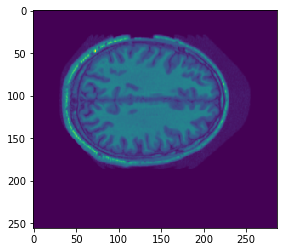

In [8]:
plt.imshow(i[0])

In [9]:
# import dipy
# import matplotlib.pylab as plt

# from dipy.data import get_data
# from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
# from dipy.align.metrics import SSDMetric, CCMetric, EMMetric
# import dipy.align.imwarp as imwarp
# from dipy.viz import regtools

In [10]:
# metric = SSDMetric(2)
# level_iters = [200, 100, 50, 25]
# sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter = 50)

In [11]:


# m1 = x[88].reshape([256,256])
# m2 = x[94].reshape([256,256])

# plt.imshow(m1); plt.colorbar(); plt.show()
# plt.imshow(m2); plt.colorbar(); plt.show()

# regtools.overlay_images(m1, m2, 'channel1', 'channel2', 'both channels', 'tmp.png');
# metric = SSDMetric(2)
# level_iters = [200, 100, 50, 25]
# sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter = 50)

# mapping = sdr.optimize(m1, m2)

# regtools.plot_2d_diffeomorphic_map(mapping, 10, 'diffeomorphic_map.png')
# warped_m2 = mapping.transform(m2, 'linear')

# regtools.overlay_images(m1, warped_m2, 'initial m1','Overlay','Warped m2', 'direct_warp_result.png')
# plt.imshow(warped_m2); plt.colorbar(); plt.show()

# plt.imshow(m1-warped_m2); plt.colorbar(); plt.show()
# plt.imshow(m1-m2); plt.colorbar(); plt.show()

In [5]:
num_seg = len(rest_available)+1

In [6]:
x_coordinate = np.zeros((256,256))
for i in range(256):
    x_coordinate[i:] = [i]*256    
y_coordinate = x_coordinate.copy()
y_coordinate = y_coordinate.T

In [7]:
x_coordinate = x_coordinate/255
y_coordinate = y_coordinate/255

In [8]:
class BrainImages(Dataset):
    def __init__(self, image_dir, label_dir, train_data = False, flipping = True, rotation = True, translation = True, \
                 coord = True):
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.flipping = flipping
        self.rotation = rotation
        self.translation = translation
        self.train_data = train_data
        self.coord = coord

    def __len__(self):
        return len(self.image_dir)

    def __getitem__(self,idx):
        image_path = "/gpfs/data/"+self.image_dir[idx]
        aseg_path = "/gpfs/data/"+self.label_dir[idx]
        
        img_orig = nibabel.freesurfer.mghformat.MGHImage.from_filename(image_path)
        image = img_orig.get_data().astype(np.float64)
        aseg_img = nibabel.freesurfer.mghformat.MGHImage.from_filename(aseg_path)
        aseg_img = aseg_img.get_data().astype(np.float64)

        flip = random.random() > 0.5
        angle = random.uniform(-10,10)
        dx = np.round(random.uniform(-25,25))
        dy = np.round(random.uniform(-25,25))
        
        im = Image.fromarray(image[0])
        target = Image.fromarray(aseg_img[0])
        if self.train_data:
            if self.flipping and flip:
                im = im.transpose(0)
                target = target.transpose(0)
            if self.rotation:
                im = im.rotate(angle)
                target = target.rotate(angle)
            if self.translation:
                im = im.transform((256,256),0, (1,0,dx,0,1,dy))
                target = target.transform((256,256),0,(1,0,dx,0,1,dy))
                
#        im = torch.from_numpy(np.array(im, np.float64, copy=False).reshape((1,256,256)))/255
        guassian_flag = random.random() > 0.5
        
        im = np.array(im, np.float64, copy=False)
        min_im = np.min(im)
        max_im = np.max(im)
        im = (im - min_im)/(max_im - min_im + 1e-4)
        if self.train_data and guassian_flag:
            sigma_rand = random.uniform(0.65,1.0)
            im_sigma = gaussian(im, sigma = sigma_rand)
            gamma_rand = random.uniform(1.6,2.4)
            im_sigma_gamma = exposure.adjust_gamma(im_sigma, gamma_rand)
            im = (im_sigma_gamma - np.min(im_sigma_gamma))/(np.max(im_sigma_gamma)-np.min(im_sigma_gamma)+1e-4)
        
        
        if self.coord:
            im = np.array([im, x_coordinate, y_coordinate], np.float64, copy=False)
            im = torch.from_numpy(im).type(torch.FloatTensor)
        else:
            im = torch.from_numpy(im).type(torch.FloatTensor).unsqueeze(0)

        target = np.array(target, np.float64, copy=False)
        target_label = np.zeros((len(rest_available)+1,256,256))
        for i,a in enumerate(available_segments):
            temp = (target==a).astype(int)
            if a in rest_available:
                target_label[rest_available.index(a),:,:] = temp
            else:
                target_label[len(rest_available),:,:] = target_label[len(rest_available),:,:] + temp
        target_label[len(rest_available),:,:] = (target_label[len(rest_available),:,:]>=1).astype(int) 
#        print(target_label.shape)
        target_label = torch.from_numpy(target_label).type(torch.FloatTensor)
        sample = {'x':im,'y':target_label} 
        return sample

In [9]:
file_names = pd.read_csv("all_complete_path.csv")

In [10]:
train_subjects = unpickling("train_subject_index")
val_subjects = unpickling("val_subject_index")
test_subjects = unpickling("test_subject_index")

In [11]:
full_train_raw = list(file_names.iloc[train_subjects,2])
full_train_seg = list(file_names.iloc[train_subjects,3])

full_val_raw = list(file_names.iloc[val_subjects,2])
full_val_seg = list(file_names.iloc[val_subjects,3])

full_test_raw = list(file_names.iloc[test_subjects,2])
full_test_seg = list(file_names.iloc[test_subjects,3])

In [12]:
277*18

4986

In [13]:
rand1 = np.arange(len(full_train_raw))
np.random.shuffle(rand1)
rand1 = rand1[:5000]

rand2 = np.arange(len(val_subjects))
np.random.shuffle(rand2)
rand2 = rand2[:1000]

rand3 = np.arange(len(test_subjects))
np.random.shuffle(rand3)
rand3 = rand3[:3]

In [14]:
cd = False
transformed_dataset = {'train': BrainImages(np.array(full_train_raw)[rand1],np.array(full_train_seg)[rand1], train_data= True, flipping=False, coord = cd),
                       'validate': BrainImages(np.array(full_val_raw)[rand2],np.array(full_val_seg)[rand2], coord = cd),
                       'test': BrainImages(np.array(full_test_raw)[rand3],np.array(full_test_seg)[rand3], coord = cd)
                                               }
bs = 12
dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs,
                        shuffle=True, num_workers=0) for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}

In [15]:
data = next(iter(dataloader['train']))

In [16]:
data['y'].size()

torch.Size([12, 46, 256, 256])

In [17]:
data['x'].size()

torch.Size([12, 1, 256, 256])

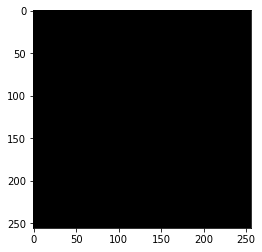

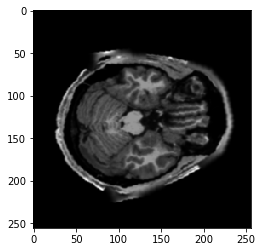

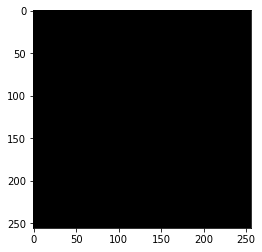

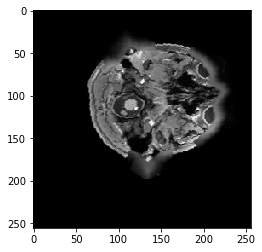

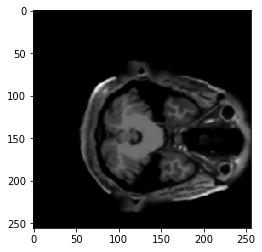

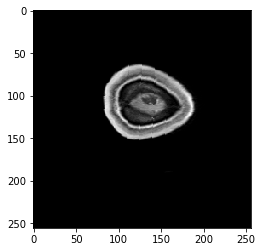

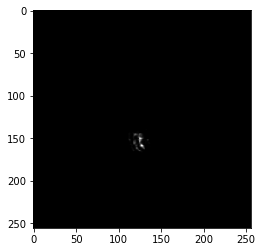

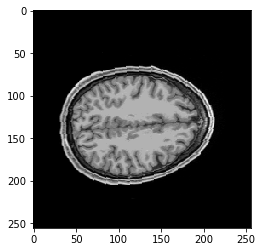

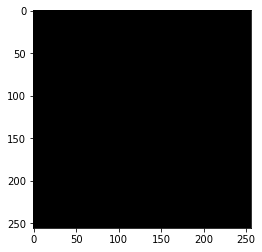

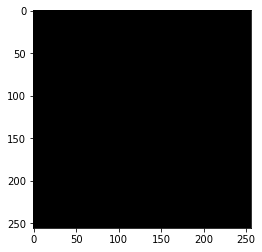

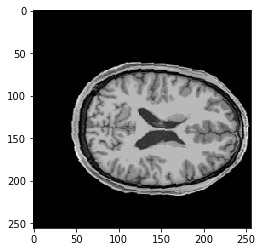

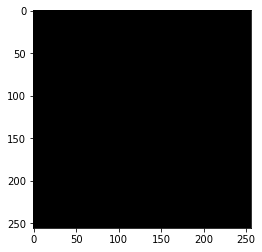

In [42]:
for i in range(bs):
    plt.imshow(data['x'][i,0,:,:],cmap='gray')
    plt.show()

In [25]:
# list_arr = []
# for data in dataloader["train"]:
#     y = data['y'].numpy()
#     N,C,_,_ = y.shape
#     sum_arr = np.sum(y.reshape(N,C,-1),axis = 2)
#     list_arr.append(sum_arr)
# final_arr = np.concatenate(list_arr,axis = 0)
# freq_class = np.true_divide(final_arr.sum(0),(final_arr!=0).sum(0)*(256*256))
# class_wts = np.median(freq_class)/freq_class
# pickling(class_wts,'new_class_wts_46_seg')

In [18]:
class_wts = unpickling('new_class_wts_46_seg')

In [19]:
class Downsample_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self,x):
        x = F.relu(self.bn1(self.conv1(x)))
        y = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(y, 2,stride = 2)
        
        return x, y

In [20]:
class Upsample_block(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Upsample_block, self).__init__()
        self.transconv = nn.ConvTranspose2d(in_channels, out_channels, 4, padding = 1, stride = 2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self,x, y):
        x = self.transconv(x)
        x = torch.cat((x,y),dim = 1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        
        return x

In [21]:
class Unet(nn.Module):
    def __init__(self,in_chan = 3, out_chan = 3):
        super(Unet, self).__init__()
        self.down1 = Downsample_block(in_chan,64)
        self.down2 = Downsample_block(64,128)
        self.down3 = Downsample_block(128,256)
        self.down4 = Downsample_block(256,512)
        self.conv1 = nn.Conv2d(512,1024, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.conv2 = nn.Conv2d(1024,1024,3, padding = 1)
        self.bn2 = nn.BatchNorm2d(1024)
        self.up4 = Upsample_block(1024,512)
        self.up3 = Upsample_block(512,256)
        self.up2 = Upsample_block(256,128)
        self.up1 = Upsample_block(128,64)
        self.outconv = nn.Conv2d(64,out_chan, 1)
        
    def forward(self,x):
        x, y1 = self.down1(x)
        x, y2 = self.down2(x)
        x, y3 = self.down3(x)
        x, y4 = self.down4(x)
        x = F.dropout2d(F.relu(self.bn1(self.conv1(x))))
        x = F.dropout2d(F.relu(self.bn2(self.conv2(x))))
        x = self.up4(x, y4)
        x = self.up3(x, y3)
        x = self.up2(x, y2)
        x = self.up1(x, y1)
        x = self.outconv(x)
        
        return x

In [22]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        I.xavier_normal(m.weight.data)

In [23]:
wts_torch = Variable(torch.from_numpy(class_wts)).cuda()

In [24]:
def get_gradient(true):
    true = true.data.cpu().numpy()
    N,C,sh1,sh2 = true.shape
    grads = []
    for i in range(N):
        grad_chan = []
        for j in range(C):
            sx = ndimage.sobel(true_out[i,j],axis=0,mode='constant')
            sy = ndimage.sobel(true_out[i,j],axis=1,mode='constant')
            sobel=np.hypot(sx,sy)
            grad_chan.append(sobel)
        grad_chan = np.vstack(grad_chan)
        grads.append(grad_chan)
    grads = np.vstack(grads)
    grads_mask = torch.from_numpy((np.absolute(grads)>0)).type(torch.cuda.FloatTensor)
    
    return grads_mask.view(N,C,-1)

In [25]:
def dice_loss_2(true,scores,mean, epsilon = 1e-4,p = 2,we = 0.05):
#     N, C, sh1, sh2 = true1.size()
    
#     true = []
#     scores = []
#     for c in range(N):
#         if not torch.sum(true1[c,1:,:,:])==0:
#             true.append(true1[c,:,:,:])
#             scores.append(scores1[c,:,:,:])
#     try:
#         true = torch.stack(true)
#         scores = torch.stack(scores)
#     except:
#         return -1
    
    
    
    N, C, sh1, sh2 = true.size()
#     grad_mask = get_gradient(true)
#     grad_mask = grad_mask.view(N,C,-1)
    
    preds = F.softmax(scores, dim = 1)
    true = true.view(N, C, -1)
    preds = preds.view(N, C, -1)
    wts = torch.sum(true, dim = 2) + epsilon
#     mean = 1/torch.pow(mean,p)
    wts[:,:] = mean[None].repeat(N,1)
#     wts = wts/(torch.sum(wts,dim = 1)[:,None])
#     print(wts)
    grad_wts = torch.max(mean)
    prod = torch.sum(true*preds,dim = 2)
    sum_tnp = torch.sum(true + preds, dim = 2)
    num = torch.sum(wts * prod, dim = 1)
    denom = torch.sum(wts * sum_tnp, dim = 1) + epsilon
    loss = 1 - 2*(num/denom)
#     cel = -torch.sum(wts * torch.sum(true*torch.log(preds),dim = 2),dim = 1)
#     grad_loss = -torch.sum(2*grad_wts * torch.sum(grad_mask*torch.log(preds),dim = 2),dim = 1)
#     return 40*torch.mean(loss)+we*torch.mean(cel)
    return torch.mean(loss)

In [26]:
def dice_score(true,scores, epsilon = 1e-7):
#     N ,C, sh1, sh2 = true1.size()
#     true = []
#     scores = []
#     for c in range(N):
#         if not torch.sum(true1[c,1:,:,:])==0:
#             true.append(true1[c,:,:,:])
#             scores.append(scores1[c,:,:,:])
#     try:
#         true = torch.stack(true)
#         scores = torch.stack(scores)
#     except:
#         return 0
    
    N, C, sh1, sh2 = true.size()
    
    true = true.view(N,C,-1)
    preds = F.softmax(scores, dim = 1)
    pred_class = (torch.max(preds, dim = 1)[1]).view(N,-1)
    class_score = [0]*C
    for i in range(C):
        class_score[i] = (pred_class == i).data.type(torch.cuda.FloatTensor)
    true = true.data.type(torch.cuda.FloatTensor)
    def numerator(truth,pred, idx):
        return(torch.sum(truth[:,idx,:] * pred,dim = 1)) + epsilon/2
    def denominator(truth,pred,idx):
        return(torch.sum(truth[:,idx,:]+pred,dim = 1)) + epsilon
    dice_class_score = [0]*C
    for i in range(C):
        dice_class_score[i] = torch.mean(2*(numerator(true,class_score[i],i))/(denominator(true,class_score[i],i)))
    return dice_class_score
    

In [27]:
import time
def train_model(model, optimizer,dataloader, name,num_seg = 3, num_epochs = 100, verbose = False, every = 1,\
                print_all_ds = True):
    since = time.time()
    best_loss = np.inf
    best_score = 0
    loss_hist = {'train':[],'validate':[]}
    dice_scores_of_all_class = [{'train':[],'validate':[]} for i in range(num_seg)]    
    for i in range(num_epochs):
        for phase in ['train', 'validate']:
            running_loss = 0
            run_class_scores = [0]*num_seg
            running_total = 0
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)
    
            for data in dataloader[phase]:
                optimizer.zero_grad()
                x = data['x']
                y = data['y']
                x = Variable(x).cuda()
                y = Variable(y).cuda()
                N, C, sh1, sh2 = y.size()
                rand_num = np.random.rand()
                if rand_num < 0.90:
                    y_mask = (torch.sum(y[:,:(C-1),:,:].contiguous().view(N,-1),dim = 1) != 0)
                    y = y[y_mask]
                    x = x[y_mask]
#                 for sel in range(x.size()[0]):
#                     if torch.sum(y[sel,0,:,:]) != 0:
#                         y_sel.append(y[sel,:,:,:])
#                         x_sel.append(x[sel,:,:,:])

#                 try:
#                     y_sel = torch.stack(y_sel)
#                     output_sel = torch.stack(output_sel)
#                 except:
#                     continue
#                 output = model(x)
                try:
                    output = model(x)
                except:
                    continue
                loss = dice_loss_2(y, output,wts_torch)
                #loss = Variable(dice_loss_2(y_sel, output_sel,wts_torch),requires_grad=True)
                if loss==-1:
                    continue
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += loss.data[0] * N
                running_total += N
                dice_score_batch = dice_score(y,output)

                for j in range(num_seg):
                    run_class_scores[j] += dice_score_batch[j] * N
            epoch_loss = running_loss/running_total
            loss_hist[phase].append(epoch_loss.item())
            epoch_score = 0
            for j in range(num_seg):
                score = run_class_scores[j]/running_total
                dice_scores_of_all_class[j][phase].append(score.item())
                if j < num_seg - 1:
                    epoch_score += score.item()
            epoch_score_av = epoch_score/ (num_seg - 1)
            if verbose or i%every == 0:
                print('Epoch: {}, Phase: {}, epoch loss: {:.4f}, Av. Dice Score: {:.4f}'\
                      .format(i,phase,epoch_loss,epoch_score_av))
#                 epoch_score = 0
                if print_all_ds:
                    for j in range(num_seg - 1):
                        print('Class {} (DS): {:.4f}'.format(j,dice_scores_of_all_class[j][phase][-1]))
    #                 epoch_score += dice_scores_of_all_class[j][phase][-1]
    #             epoch_score_av = epoch_score / (num_seg - 1)
                print('-'*10)
            
        if phase == 'validate' and epoch_score_av > best_score:
            best_loss = epoch_loss
            best_score = epoch_score_av
            best_model_wts = model.state_dict()
            torch.save(model,name)
        #print(i)
    print('-'*50)    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val dice loss: {:4f}, Best Average DS: {:4f}'.format(best_loss,best_score))
    
    model.load_state_dict(best_model_wts)
    pickling(loss_hist,name+'loss_hist')
    pickling(dice_scores_of_all_class,name+'dice_hist')
    
    return model, loss_hist, dice_scores_of_all_class

In [28]:
model = Unet(in_chan = 1,out_chan = num_seg).cuda()
model.apply(weights_init)
model = nn.DataParallel(model)
criterion = dice_loss_2
#scheduler = lr_scheduler.StepLR(optimizer,step_size = 15)

In [29]:
optimizer = optim.Adam(model.parameters(),lr = 1e-4)

In [30]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,'exp_1_only_dice_loss_lr_1e-4',num_seg = num_seg, num_epochs = 30,\
                                         every = 1, print_all_ds = True)

Epoch: 0, Phase: train, epoch loss: 0.9990, Av. Dice Score: 0.3539
Class 0 (DS): 0.2187
Class 1 (DS): 0.1812
Class 2 (DS): 0.7681
Class 3 (DS): 0.3462
Class 4 (DS): 0.0015
Class 5 (DS): 0.0192
Class 6 (DS): 0.0064
Class 7 (DS): 0.0761
Class 8 (DS): 0.0016
Class 9 (DS): 0.7842
Class 10 (DS): 0.4341
Class 11 (DS): 0.0285
Class 12 (DS): 0.0177
Class 13 (DS): 0.2371
Class 14 (DS): 0.4092
Class 15 (DS): 0.6975
Class 16 (DS): 0.5583
Class 17 (DS): 0.1831
Class 18 (DS): 0.7529
Class 19 (DS): 0.4299
Class 20 (DS): 0.0460
Class 21 (DS): 0.0833
Class 22 (DS): 0.0300
Class 23 (DS): 0.5801
Class 24 (DS): 0.0179
Class 25 (DS): 0.1919
Class 26 (DS): 0.0228
Class 27 (DS): 0.1367
Class 28 (DS): 0.3402
Class 29 (DS): 0.6148
Class 30 (DS): 0.0189
Class 31 (DS): 0.3758
Class 32 (DS): 0.5880
Class 33 (DS): 0.0865
Class 34 (DS): 0.9627
Class 35 (DS): 0.4984
Class 36 (DS): 0.6534
Class 37 (DS): 0.0037
Class 38 (DS): 0.9035
Class 39 (DS): 0.7465
Class 40 (DS): 0.4974
Class 41 (DS): 0.5301
Class 42 (DS): 0.58

Epoch: 4, Phase: train, epoch loss: 0.3560, Av. Dice Score: 0.8311
Class 0 (DS): 0.7542
Class 1 (DS): 0.7425
Class 2 (DS): 0.7964
Class 3 (DS): 0.9109
Class 4 (DS): 0.6982
Class 5 (DS): 0.5787
Class 6 (DS): 0.8337
Class 7 (DS): 0.8927
Class 8 (DS): 0.8188
Class 9 (DS): 0.8920
Class 10 (DS): 0.8419
Class 11 (DS): 0.8489
Class 12 (DS): 0.7947
Class 13 (DS): 0.7731
Class 14 (DS): 0.8828
Class 15 (DS): 0.8792
Class 16 (DS): 0.8979
Class 17 (DS): 0.8599
Class 18 (DS): 0.9732
Class 19 (DS): 0.7465
Class 20 (DS): 0.7843
Class 21 (DS): 0.6822
Class 22 (DS): 0.7942
Class 23 (DS): 0.9125
Class 24 (DS): 0.6990
Class 25 (DS): 0.5715
Class 26 (DS): 0.8415
Class 27 (DS): 0.7800
Class 28 (DS): 0.8217
Class 29 (DS): 0.8949
Class 30 (DS): 0.7694
Class 31 (DS): 0.8725
Class 32 (DS): 0.9051
Class 33 (DS): 0.8578
Class 34 (DS): 0.9658
Class 35 (DS): 0.7302
Class 36 (DS): 0.9925
Class 37 (DS): 0.7441
Class 38 (DS): 0.9626
Class 39 (DS): 0.9488
Class 40 (DS): 0.8769
Class 41 (DS): 0.9175
Class 42 (DS): 0.90

Epoch: 8, Phase: train, epoch loss: 0.3065, Av. Dice Score: 0.8439
Class 0 (DS): 0.8247
Class 1 (DS): 0.8300
Class 2 (DS): 0.7987
Class 3 (DS): 0.9125
Class 4 (DS): 0.6961
Class 5 (DS): 0.5790
Class 6 (DS): 0.8343
Class 7 (DS): 0.9406
Class 8 (DS): 0.8176
Class 9 (DS): 0.8924
Class 10 (DS): 0.8430
Class 11 (DS): 0.8904
Class 12 (DS): 0.8754
Class 13 (DS): 0.7740
Class 14 (DS): 0.8837
Class 15 (DS): 0.8794
Class 16 (DS): 0.8994
Class 17 (DS): 0.8594
Class 18 (DS): 0.9713
Class 19 (DS): 0.7460
Class 20 (DS): 0.8727
Class 21 (DS): 0.8181
Class 22 (DS): 0.7970
Class 23 (DS): 0.9133
Class 24 (DS): 0.6989
Class 25 (DS): 0.5710
Class 26 (DS): 0.8417
Class 27 (DS): 0.7842
Class 28 (DS): 0.8203
Class 29 (DS): 0.8977
Class 30 (DS): 0.7713
Class 31 (DS): 0.8723
Class 32 (DS): 0.9063
Class 33 (DS): 0.8581
Class 34 (DS): 0.9654
Class 35 (DS): 0.7322
Class 36 (DS): 0.9918
Class 37 (DS): 0.7451
Class 38 (DS): 0.9649
Class 39 (DS): 0.9489
Class 40 (DS): 0.8778
Class 41 (DS): 0.9208
Class 42 (DS): 0.90

Epoch: 12, Phase: train, epoch loss: 0.3017, Av. Dice Score: 0.8472
Class 0 (DS): 0.8575
Class 1 (DS): 0.8376
Class 2 (DS): 0.7988
Class 3 (DS): 0.9146
Class 4 (DS): 0.6971
Class 5 (DS): 0.5784
Class 6 (DS): 0.8361
Class 7 (DS): 0.9434
Class 8 (DS): 0.8218
Class 9 (DS): 0.8945
Class 10 (DS): 0.8455
Class 11 (DS): 0.9079
Class 12 (DS): 0.9009
Class 13 (DS): 0.7774
Class 14 (DS): 0.8851
Class 15 (DS): 0.8813
Class 16 (DS): 0.9016
Class 17 (DS): 0.8640
Class 18 (DS): 0.9739
Class 19 (DS): 0.7494
Class 20 (DS): 0.8753
Class 21 (DS): 0.8193
Class 22 (DS): 0.7976
Class 23 (DS): 0.9143
Class 24 (DS): 0.7001
Class 25 (DS): 0.5700
Class 26 (DS): 0.8442
Class 27 (DS): 0.7841
Class 28 (DS): 0.8242
Class 29 (DS): 0.8993
Class 30 (DS): 0.7741
Class 31 (DS): 0.8742
Class 32 (DS): 0.9085
Class 33 (DS): 0.8632
Class 34 (DS): 0.9658
Class 35 (DS): 0.7370
Class 36 (DS): 0.9924
Class 37 (DS): 0.7469
Class 38 (DS): 0.9625
Class 39 (DS): 0.9510
Class 40 (DS): 0.8773
Class 41 (DS): 0.9179
Class 42 (DS): 0.9

Epoch: 16, Phase: train, epoch loss: 0.2995, Av. Dice Score: 0.8474
Class 0 (DS): 0.8758
Class 1 (DS): 0.8524
Class 2 (DS): 0.7959
Class 3 (DS): 0.9112
Class 4 (DS): 0.6997
Class 5 (DS): 0.5830
Class 6 (DS): 0.8306
Class 7 (DS): 0.9472
Class 8 (DS): 0.8194
Class 9 (DS): 0.8952
Class 10 (DS): 0.8430
Class 11 (DS): 0.9101
Class 12 (DS): 0.9057
Class 13 (DS): 0.7763
Class 14 (DS): 0.8839
Class 15 (DS): 0.8760
Class 16 (DS): 0.9020
Class 17 (DS): 0.8617
Class 18 (DS): 0.9737
Class 19 (DS): 0.7450
Class 20 (DS): 0.8830
Class 21 (DS): 0.8346
Class 22 (DS): 0.7941
Class 23 (DS): 0.9139
Class 24 (DS): 0.7024
Class 25 (DS): 0.5756
Class 26 (DS): 0.8378
Class 27 (DS): 0.7790
Class 28 (DS): 0.8221
Class 29 (DS): 0.8980
Class 30 (DS): 0.7731
Class 31 (DS): 0.8737
Class 32 (DS): 0.9095
Class 33 (DS): 0.8601
Class 34 (DS): 0.9670
Class 35 (DS): 0.7290
Class 36 (DS): 0.9921
Class 37 (DS): 0.7427
Class 38 (DS): 0.9635
Class 39 (DS): 0.9490
Class 40 (DS): 0.8745
Class 41 (DS): 0.9181
Class 42 (DS): 0.9

Epoch: 20, Phase: train, epoch loss: 0.2926, Av. Dice Score: 0.8503
Class 0 (DS): 0.8865
Class 1 (DS): 0.8562
Class 2 (DS): 0.7959
Class 3 (DS): 0.9147
Class 4 (DS): 0.7039
Class 5 (DS): 0.5846
Class 6 (DS): 0.8329
Class 7 (DS): 0.9503
Class 8 (DS): 0.8180
Class 9 (DS): 0.8940
Class 10 (DS): 0.8433
Class 11 (DS): 0.9229
Class 12 (DS): 0.9176
Class 13 (DS): 0.7789
Class 14 (DS): 0.8883
Class 15 (DS): 0.8774
Class 16 (DS): 0.9019
Class 17 (DS): 0.8659
Class 18 (DS): 0.9738
Class 19 (DS): 0.7505
Class 20 (DS): 0.8935
Class 21 (DS): 0.8481
Class 22 (DS): 0.7943
Class 23 (DS): 0.9176
Class 24 (DS): 0.7066
Class 25 (DS): 0.5768
Class 26 (DS): 0.8404
Class 27 (DS): 0.7815
Class 28 (DS): 0.8217
Class 29 (DS): 0.8968
Class 30 (DS): 0.7760
Class 31 (DS): 0.8781
Class 32 (DS): 0.9090
Class 33 (DS): 0.8651
Class 34 (DS): 0.9678
Class 35 (DS): 0.7360
Class 36 (DS): 0.9917
Class 37 (DS): 0.7427
Class 38 (DS): 0.9619
Class 39 (DS): 0.9508
Class 40 (DS): 0.8766
Class 41 (DS): 0.9191
Class 42 (DS): 0.9

Epoch: 24, Phase: train, epoch loss: 0.2894, Av. Dice Score: 0.8520
Class 0 (DS): 0.8910
Class 1 (DS): 0.8697
Class 2 (DS): 0.8014
Class 3 (DS): 0.9136
Class 4 (DS): 0.6977
Class 5 (DS): 0.5806
Class 6 (DS): 0.8356
Class 7 (DS): 0.9545
Class 8 (DS): 0.8213
Class 9 (DS): 0.8935
Class 10 (DS): 0.8450
Class 11 (DS): 0.9211
Class 12 (DS): 0.9238
Class 13 (DS): 0.7798
Class 14 (DS): 0.8883
Class 15 (DS): 0.8824
Class 16 (DS): 0.9005
Class 17 (DS): 0.8639
Class 18 (DS): 0.9717
Class 19 (DS): 0.7523
Class 20 (DS): 0.9020
Class 21 (DS): 0.8589
Class 22 (DS): 0.8000
Class 23 (DS): 0.9159
Class 24 (DS): 0.6998
Class 25 (DS): 0.5718
Class 26 (DS): 0.8435
Class 27 (DS): 0.7866
Class 28 (DS): 0.8243
Class 29 (DS): 0.8975
Class 30 (DS): 0.7760
Class 31 (DS): 0.8775
Class 32 (DS): 0.9071
Class 33 (DS): 0.8628
Class 34 (DS): 0.9653
Class 35 (DS): 0.7384
Class 36 (DS): 0.9921
Class 37 (DS): 0.7506
Class 38 (DS): 0.9645
Class 39 (DS): 0.9515
Class 40 (DS): 0.8802
Class 41 (DS): 0.9206
Class 42 (DS): 0.9

Epoch: 28, Phase: train, epoch loss: 0.2906, Av. Dice Score: 0.8501
Class 0 (DS): 0.8999
Class 1 (DS): 0.8688
Class 2 (DS): 0.7961
Class 3 (DS): 0.9113
Class 4 (DS): 0.6984
Class 5 (DS): 0.5824
Class 6 (DS): 0.8327
Class 7 (DS): 0.9528
Class 8 (DS): 0.8179
Class 9 (DS): 0.8914
Class 10 (DS): 0.8409
Class 11 (DS): 0.9240
Class 12 (DS): 0.9235
Class 13 (DS): 0.7741
Class 14 (DS): 0.8831
Class 15 (DS): 0.8756
Class 16 (DS): 0.9005
Class 17 (DS): 0.8611
Class 18 (DS): 0.9720
Class 19 (DS): 0.7478
Class 20 (DS): 0.9103
Class 21 (DS): 0.8615
Class 22 (DS): 0.7949
Class 23 (DS): 0.9134
Class 24 (DS): 0.7008
Class 25 (DS): 0.5747
Class 26 (DS): 0.8404
Class 27 (DS): 0.7820
Class 28 (DS): 0.8189
Class 29 (DS): 0.8949
Class 30 (DS): 0.7704
Class 31 (DS): 0.8729
Class 32 (DS): 0.9059
Class 33 (DS): 0.8603
Class 34 (DS): 0.9651
Class 35 (DS): 0.7308
Class 36 (DS): 0.9918
Class 37 (DS): 0.7425
Class 38 (DS): 0.9627
Class 39 (DS): 0.9493
Class 40 (DS): 0.8762
Class 41 (DS): 0.9190
Class 42 (DS): 0.9

In [31]:
optimizer = optim.Adam(model.parameters(),lr = 5e-5)

In [32]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,'exp_2_only_dice_loss_lr_5e-5',num_seg = num_seg, num_epochs = 30,\
                                         every = 1, print_all_ds = True)

Epoch: 0, Phase: train, epoch loss: 0.2896, Av. Dice Score: 0.8518
Class 0 (DS): 0.9050
Class 1 (DS): 0.8824
Class 2 (DS): 0.7979
Class 3 (DS): 0.9126
Class 4 (DS): 0.6953
Class 5 (DS): 0.5782
Class 6 (DS): 0.8342
Class 7 (DS): 0.9567
Class 8 (DS): 0.8180
Class 9 (DS): 0.8938
Class 10 (DS): 0.8426
Class 11 (DS): 0.9246
Class 12 (DS): 0.9330
Class 13 (DS): 0.7784
Class 14 (DS): 0.8863
Class 15 (DS): 0.8782
Class 16 (DS): 0.9011
Class 17 (DS): 0.8617
Class 18 (DS): 0.9724
Class 19 (DS): 0.7503
Class 20 (DS): 0.9106
Class 21 (DS): 0.8703
Class 22 (DS): 0.7960
Class 23 (DS): 0.9142
Class 24 (DS): 0.6972
Class 25 (DS): 0.5693
Class 26 (DS): 0.8406
Class 27 (DS): 0.7837
Class 28 (DS): 0.8217
Class 29 (DS): 0.8976
Class 30 (DS): 0.7741
Class 31 (DS): 0.8750
Class 32 (DS): 0.9076
Class 33 (DS): 0.8608
Class 34 (DS): 0.9657
Class 35 (DS): 0.7348
Class 36 (DS): 0.9912
Class 37 (DS): 0.7434
Class 38 (DS): 0.9626
Class 39 (DS): 0.9496
Class 40 (DS): 0.8770
Class 41 (DS): 0.9211
Class 42 (DS): 0.90

Epoch: 4, Phase: train, epoch loss: 0.2796, Av. Dice Score: 0.8563
Class 0 (DS): 0.9156
Class 1 (DS): 0.8864
Class 2 (DS): 0.8064
Class 3 (DS): 0.9143
Class 4 (DS): 0.7028
Class 5 (DS): 0.5865
Class 6 (DS): 0.8436
Class 7 (DS): 0.9601
Class 8 (DS): 0.8250
Class 9 (DS): 0.8980
Class 10 (DS): 0.8468
Class 11 (DS): 0.9251
Class 12 (DS): 0.9375
Class 13 (DS): 0.7809
Class 14 (DS): 0.8854
Class 15 (DS): 0.8868
Class 16 (DS): 0.9021
Class 17 (DS): 0.8625
Class 18 (DS): 0.9732
Class 19 (DS): 0.7572
Class 20 (DS): 0.9146
Class 21 (DS): 0.8797
Class 22 (DS): 0.8048
Class 23 (DS): 0.9149
Class 24 (DS): 0.7051
Class 25 (DS): 0.5770
Class 26 (DS): 0.8504
Class 27 (DS): 0.7919
Class 28 (DS): 0.8290
Class 29 (DS): 0.9024
Class 30 (DS): 0.7774
Class 31 (DS): 0.8740
Class 32 (DS): 0.9095
Class 33 (DS): 0.8625
Class 34 (DS): 0.9659
Class 35 (DS): 0.7428
Class 36 (DS): 0.9920
Class 37 (DS): 0.7526
Class 38 (DS): 0.9635
Class 39 (DS): 0.9481
Class 40 (DS): 0.8833
Class 41 (DS): 0.9212
Class 42 (DS): 0.90

Epoch: 8, Phase: train, epoch loss: 0.2880, Av. Dice Score: 0.8501
Class 0 (DS): 0.9131
Class 1 (DS): 0.8835
Class 2 (DS): 0.7973
Class 3 (DS): 0.9101
Class 4 (DS): 0.6955
Class 5 (DS): 0.5788
Class 6 (DS): 0.8303
Class 7 (DS): 0.9581
Class 8 (DS): 0.8136
Class 9 (DS): 0.8897
Class 10 (DS): 0.8377
Class 11 (DS): 0.9268
Class 12 (DS): 0.9328
Class 13 (DS): 0.7698
Class 14 (DS): 0.8832
Class 15 (DS): 0.8790
Class 16 (DS): 0.8953
Class 17 (DS): 0.8570
Class 18 (DS): 0.9709
Class 19 (DS): 0.7416
Class 20 (DS): 0.9198
Class 21 (DS): 0.8833
Class 22 (DS): 0.7953
Class 23 (DS): 0.9135
Class 24 (DS): 0.6967
Class 25 (DS): 0.5692
Class 26 (DS): 0.8374
Class 27 (DS): 0.7777
Class 28 (DS): 0.8173
Class 29 (DS): 0.8932
Class 30 (DS): 0.7657
Class 31 (DS): 0.8716
Class 32 (DS): 0.9024
Class 33 (DS): 0.8563
Class 34 (DS): 0.9646
Class 35 (DS): 0.7277
Class 36 (DS): 0.9918
Class 37 (DS): 0.7421
Class 38 (DS): 0.9631
Class 39 (DS): 0.9496
Class 40 (DS): 0.8770
Class 41 (DS): 0.9188
Class 42 (DS): 0.90

Epoch: 12, Phase: train, epoch loss: 0.2867, Av. Dice Score: 0.8519
Class 0 (DS): 0.9166
Class 1 (DS): 0.8887
Class 2 (DS): 0.7987
Class 3 (DS): 0.9096
Class 4 (DS): 0.6962
Class 5 (DS): 0.5780
Class 6 (DS): 0.8352
Class 7 (DS): 0.9566
Class 8 (DS): 0.8188
Class 9 (DS): 0.8930
Class 10 (DS): 0.8419
Class 11 (DS): 0.9262
Class 12 (DS): 0.9402
Class 13 (DS): 0.7725
Class 14 (DS): 0.8815
Class 15 (DS): 0.8798
Class 16 (DS): 0.9002
Class 17 (DS): 0.8587
Class 18 (DS): 0.9717
Class 19 (DS): 0.7457
Class 20 (DS): 0.9163
Class 21 (DS): 0.8817
Class 22 (DS): 0.7973
Class 23 (DS): 0.9104
Class 24 (DS): 0.6998
Class 25 (DS): 0.5717
Class 26 (DS): 0.8431
Class 27 (DS): 0.7833
Class 28 (DS): 0.8217
Class 29 (DS): 0.8974
Class 30 (DS): 0.7705
Class 31 (DS): 0.8709
Class 32 (DS): 0.9078
Class 33 (DS): 0.8564
Class 34 (DS): 0.9656
Class 35 (DS): 0.7317
Class 36 (DS): 0.9922
Class 37 (DS): 0.7443
Class 38 (DS): 0.9632
Class 39 (DS): 0.9460
Class 40 (DS): 0.8763
Class 41 (DS): 0.9190
Class 42 (DS): 0.9

Epoch: 16, Phase: train, epoch loss: 0.2867, Av. Dice Score: 0.8520
Class 0 (DS): 0.9164
Class 1 (DS): 0.8889
Class 2 (DS): 0.7974
Class 3 (DS): 0.9121
Class 4 (DS): 0.6942
Class 5 (DS): 0.5785
Class 6 (DS): 0.8328
Class 7 (DS): 0.9590
Class 8 (DS): 0.8166
Class 9 (DS): 0.8940
Class 10 (DS): 0.8417
Class 11 (DS): 0.9326
Class 12 (DS): 0.9409
Class 13 (DS): 0.7721
Class 14 (DS): 0.8815
Class 15 (DS): 0.8779
Class 16 (DS): 0.8992
Class 17 (DS): 0.8606
Class 18 (DS): 0.9730
Class 19 (DS): 0.7453
Class 20 (DS): 0.9202
Class 21 (DS): 0.8845
Class 22 (DS): 0.7947
Class 23 (DS): 0.9130
Class 24 (DS): 0.6966
Class 25 (DS): 0.5713
Class 26 (DS): 0.8402
Class 27 (DS): 0.7818
Class 28 (DS): 0.8208
Class 29 (DS): 0.8975
Class 30 (DS): 0.7699
Class 31 (DS): 0.8703
Class 32 (DS): 0.9066
Class 33 (DS): 0.8596
Class 34 (DS): 0.9664
Class 35 (DS): 0.7319
Class 36 (DS): 0.9915
Class 37 (DS): 0.7450
Class 38 (DS): 0.9621
Class 39 (DS): 0.9490
Class 40 (DS): 0.8777
Class 41 (DS): 0.9178
Class 42 (DS): 0.9

Epoch: 20, Phase: train, epoch loss: 0.2869, Av. Dice Score: 0.8515
Class 0 (DS): 0.9192
Class 1 (DS): 0.8900
Class 2 (DS): 0.7940
Class 3 (DS): 0.9121
Class 4 (DS): 0.6991
Class 5 (DS): 0.5799
Class 6 (DS): 0.8306
Class 7 (DS): 0.9580
Class 8 (DS): 0.8154
Class 9 (DS): 0.8910
Class 10 (DS): 0.8420
Class 11 (DS): 0.9332
Class 12 (DS): 0.9366
Class 13 (DS): 0.7727
Class 14 (DS): 0.8831
Class 15 (DS): 0.8752
Class 16 (DS): 0.8992
Class 17 (DS): 0.8622
Class 18 (DS): 0.9725
Class 19 (DS): 0.7458
Class 20 (DS): 0.9206
Class 21 (DS): 0.8891
Class 22 (DS): 0.7907
Class 23 (DS): 0.9141
Class 24 (DS): 0.7026
Class 25 (DS): 0.5721
Class 26 (DS): 0.8379
Class 27 (DS): 0.7788
Class 28 (DS): 0.8199
Class 29 (DS): 0.8951
Class 30 (DS): 0.7691
Class 31 (DS): 0.8718
Class 32 (DS): 0.9061
Class 33 (DS): 0.8612
Class 34 (DS): 0.9655
Class 35 (DS): 0.7289
Class 36 (DS): 0.9915
Class 37 (DS): 0.7402
Class 38 (DS): 0.9636
Class 39 (DS): 0.9499
Class 40 (DS): 0.8733
Class 41 (DS): 0.9163
Class 42 (DS): 0.9

Epoch: 24, Phase: train, epoch loss: 0.2823, Av. Dice Score: 0.8538
Class 0 (DS): 0.9217
Class 1 (DS): 0.8890
Class 2 (DS): 0.7958
Class 3 (DS): 0.9135
Class 4 (DS): 0.7006
Class 5 (DS): 0.5879
Class 6 (DS): 0.8334
Class 7 (DS): 0.9586
Class 8 (DS): 0.8197
Class 9 (DS): 0.8957
Class 10 (DS): 0.8460
Class 11 (DS): 0.9314
Class 12 (DS): 0.9411
Class 13 (DS): 0.7777
Class 14 (DS): 0.8841
Class 15 (DS): 0.8784
Class 16 (DS): 0.9015
Class 17 (DS): 0.8631
Class 18 (DS): 0.9733
Class 19 (DS): 0.7498
Class 20 (DS): 0.9225
Class 21 (DS): 0.8893
Class 22 (DS): 0.7931
Class 23 (DS): 0.9146
Class 24 (DS): 0.7043
Class 25 (DS): 0.5787
Class 26 (DS): 0.8421
Class 27 (DS): 0.7810
Class 28 (DS): 0.8228
Class 29 (DS): 0.8991
Class 30 (DS): 0.7747
Class 31 (DS): 0.8742
Class 32 (DS): 0.9083
Class 33 (DS): 0.8625
Class 34 (DS): 0.9681
Class 35 (DS): 0.7344
Class 36 (DS): 0.9926
Class 37 (DS): 0.7430
Class 38 (DS): 0.9629
Class 39 (DS): 0.9497
Class 40 (DS): 0.8737
Class 41 (DS): 0.9167
Class 42 (DS): 0.8

Epoch: 28, Phase: train, epoch loss: 0.2825, Av. Dice Score: 0.8536
Class 0 (DS): 0.9219
Class 1 (DS): 0.8919
Class 2 (DS): 0.7990
Class 3 (DS): 0.9111
Class 4 (DS): 0.6976
Class 5 (DS): 0.5828
Class 6 (DS): 0.8335
Class 7 (DS): 0.9593
Class 8 (DS): 0.8203
Class 9 (DS): 0.8939
Class 10 (DS): 0.8435
Class 11 (DS): 0.9333
Class 12 (DS): 0.9408
Class 13 (DS): 0.7750
Class 14 (DS): 0.8832
Class 15 (DS): 0.8778
Class 16 (DS): 0.9026
Class 17 (DS): 0.8634
Class 18 (DS): 0.9736
Class 19 (DS): 0.7448
Class 20 (DS): 0.9221
Class 21 (DS): 0.8901
Class 22 (DS): 0.7967
Class 23 (DS): 0.9126
Class 24 (DS): 0.6998
Class 25 (DS): 0.5750
Class 26 (DS): 0.8410
Class 27 (DS): 0.7840
Class 28 (DS): 0.8225
Class 29 (DS): 0.8985
Class 30 (DS): 0.7723
Class 31 (DS): 0.8725
Class 32 (DS): 0.9088
Class 33 (DS): 0.8618
Class 34 (DS): 0.9664
Class 35 (DS): 0.7335
Class 36 (DS): 0.9922
Class 37 (DS): 0.7456
Class 38 (DS): 0.9612
Class 39 (DS): 0.9503
Class 40 (DS): 0.8776
Class 41 (DS): 0.9201
Class 42 (DS): 0.9

In [33]:
optimizer = optim.Adam(model.parameters(),lr = 1e-5)

In [34]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,'exp_3_only_dice_loss_lr_1e-5',num_seg = num_seg, num_epochs = 30,\
                                         every = 1, print_all_ds = True)

Epoch: 0, Phase: train, epoch loss: 0.2831, Av. Dice Score: 0.8530
Class 0 (DS): 0.9242
Class 1 (DS): 0.8989
Class 2 (DS): 0.7981
Class 3 (DS): 0.9090
Class 4 (DS): 0.6940
Class 5 (DS): 0.5804
Class 6 (DS): 0.8347
Class 7 (DS): 0.9587
Class 8 (DS): 0.8170
Class 9 (DS): 0.8926
Class 10 (DS): 0.8398
Class 11 (DS): 0.9376
Class 12 (DS): 0.9404
Class 13 (DS): 0.7723
Class 14 (DS): 0.8832
Class 15 (DS): 0.8802
Class 16 (DS): 0.8983
Class 17 (DS): 0.8577
Class 18 (DS): 0.9695
Class 19 (DS): 0.7445
Class 20 (DS): 0.9270
Class 21 (DS): 0.8964
Class 22 (DS): 0.7985
Class 23 (DS): 0.9133
Class 24 (DS): 0.6992
Class 25 (DS): 0.5722
Class 26 (DS): 0.8426
Class 27 (DS): 0.7834
Class 28 (DS): 0.8203
Class 29 (DS): 0.8981
Class 30 (DS): 0.7696
Class 31 (DS): 0.8712
Class 32 (DS): 0.9046
Class 33 (DS): 0.8568
Class 34 (DS): 0.9649
Class 35 (DS): 0.7295
Class 36 (DS): 0.9916
Class 37 (DS): 0.7441
Class 38 (DS): 0.9624
Class 39 (DS): 0.9468
Class 40 (DS): 0.8780
Class 41 (DS): 0.9193
Class 42 (DS): 0.90

Epoch: 4, Phase: train, epoch loss: 0.2796, Av. Dice Score: 0.8551
Class 0 (DS): 0.9192
Class 1 (DS): 0.8968
Class 2 (DS): 0.8025
Class 3 (DS): 0.9115
Class 4 (DS): 0.6973
Class 5 (DS): 0.5810
Class 6 (DS): 0.8381
Class 7 (DS): 0.9640
Class 8 (DS): 0.8218
Class 9 (DS): 0.8948
Class 10 (DS): 0.8455
Class 11 (DS): 0.9383
Class 12 (DS): 0.9440
Class 13 (DS): 0.7738
Class 14 (DS): 0.8803
Class 15 (DS): 0.8822
Class 16 (DS): 0.9003
Class 17 (DS): 0.8599
Class 18 (DS): 0.9727
Class 19 (DS): 0.7510
Class 20 (DS): 0.9246
Class 21 (DS): 0.8956
Class 22 (DS): 0.8014
Class 23 (DS): 0.9116
Class 24 (DS): 0.7011
Class 25 (DS): 0.5733
Class 26 (DS): 0.8457
Class 27 (DS): 0.7870
Class 28 (DS): 0.8256
Class 29 (DS): 0.8977
Class 30 (DS): 0.7713
Class 31 (DS): 0.8717
Class 32 (DS): 0.9086
Class 33 (DS): 0.8579
Class 34 (DS): 0.9663
Class 35 (DS): 0.7349
Class 36 (DS): 0.9922
Class 37 (DS): 0.7513
Class 38 (DS): 0.9650
Class 39 (DS): 0.9471
Class 40 (DS): 0.8831
Class 41 (DS): 0.9217
Class 42 (DS): 0.90

Epoch: 8, Phase: train, epoch loss: 0.2839, Av. Dice Score: 0.8536
Class 0 (DS): 0.9220
Class 1 (DS): 0.8988
Class 2 (DS): 0.7998
Class 3 (DS): 0.9105
Class 4 (DS): 0.6922
Class 5 (DS): 0.5755
Class 6 (DS): 0.8345
Class 7 (DS): 0.9625
Class 8 (DS): 0.8205
Class 9 (DS): 0.8949
Class 10 (DS): 0.8431
Class 11 (DS): 0.9358
Class 12 (DS): 0.9465
Class 13 (DS): 0.7733
Class 14 (DS): 0.8808
Class 15 (DS): 0.8794
Class 16 (DS): 0.9003
Class 17 (DS): 0.8612
Class 18 (DS): 0.9728
Class 19 (DS): 0.7465
Class 20 (DS): 0.9233
Class 21 (DS): 0.8973
Class 22 (DS): 0.7974
Class 23 (DS): 0.9116
Class 24 (DS): 0.6946
Class 25 (DS): 0.5682
Class 26 (DS): 0.8420
Class 27 (DS): 0.7836
Class 28 (DS): 0.8244
Class 29 (DS): 0.8982
Class 30 (DS): 0.7714
Class 31 (DS): 0.8719
Class 32 (DS): 0.9078
Class 33 (DS): 0.8609
Class 34 (DS): 0.9665
Class 35 (DS): 0.7321
Class 36 (DS): 0.9917
Class 37 (DS): 0.7470
Class 38 (DS): 0.9646
Class 39 (DS): 0.9476
Class 40 (DS): 0.8775
Class 41 (DS): 0.9185
Class 42 (DS): 0.90

Epoch: 12, Phase: train, epoch loss: 0.2807, Av. Dice Score: 0.8538
Class 0 (DS): 0.9221
Class 1 (DS): 0.8989
Class 2 (DS): 0.8005
Class 3 (DS): 0.9082
Class 4 (DS): 0.6954
Class 5 (DS): 0.5806
Class 6 (DS): 0.8360
Class 7 (DS): 0.9622
Class 8 (DS): 0.8191
Class 9 (DS): 0.8935
Class 10 (DS): 0.8407
Class 11 (DS): 0.9386
Class 12 (DS): 0.9464
Class 13 (DS): 0.7716
Class 14 (DS): 0.8793
Class 15 (DS): 0.8811
Class 16 (DS): 0.8979
Class 17 (DS): 0.8579
Class 18 (DS): 0.9726
Class 19 (DS): 0.7467
Class 20 (DS): 0.9298
Class 21 (DS): 0.8997
Class 22 (DS): 0.7990
Class 23 (DS): 0.9107
Class 24 (DS): 0.6983
Class 25 (DS): 0.5717
Class 26 (DS): 0.8427
Class 27 (DS): 0.7851
Class 28 (DS): 0.8212
Class 29 (DS): 0.8968
Class 30 (DS): 0.7686
Class 31 (DS): 0.8693
Class 32 (DS): 0.9053
Class 33 (DS): 0.8568
Class 34 (DS): 0.9661
Class 35 (DS): 0.7339
Class 36 (DS): 0.9920
Class 37 (DS): 0.7460
Class 38 (DS): 0.9646
Class 39 (DS): 0.9479
Class 40 (DS): 0.8801
Class 41 (DS): 0.9198
Class 42 (DS): 0.9

Epoch: 16, Phase: train, epoch loss: 0.2763, Av. Dice Score: 0.8563
Class 0 (DS): 0.9252
Class 1 (DS): 0.9021
Class 2 (DS): 0.8006
Class 3 (DS): 0.9124
Class 4 (DS): 0.7054
Class 5 (DS): 0.5886
Class 6 (DS): 0.8368
Class 7 (DS): 0.9628
Class 8 (DS): 0.8197
Class 9 (DS): 0.8969
Class 10 (DS): 0.8456
Class 11 (DS): 0.9414
Class 12 (DS): 0.9438
Class 13 (DS): 0.7781
Class 14 (DS): 0.8846
Class 15 (DS): 0.8792
Class 16 (DS): 0.9024
Class 17 (DS): 0.8646
Class 18 (DS): 0.9732
Class 19 (DS): 0.7505
Class 20 (DS): 0.9267
Class 21 (DS): 0.9008
Class 22 (DS): 0.7969
Class 23 (DS): 0.9142
Class 24 (DS): 0.7086
Class 25 (DS): 0.5806
Class 26 (DS): 0.8435
Class 27 (DS): 0.7858
Class 28 (DS): 0.8237
Class 29 (DS): 0.9001
Class 30 (DS): 0.7751
Class 31 (DS): 0.8749
Class 32 (DS): 0.9080
Class 33 (DS): 0.8630
Class 34 (DS): 0.9674
Class 35 (DS): 0.7375
Class 36 (DS): 0.9927
Class 37 (DS): 0.7466
Class 38 (DS): 0.9631
Class 39 (DS): 0.9515
Class 40 (DS): 0.8785
Class 41 (DS): 0.9184
Class 42 (DS): 0.9

Epoch: 20, Phase: train, epoch loss: 0.2800, Av. Dice Score: 0.8552
Class 0 (DS): 0.9238
Class 1 (DS): 0.9027
Class 2 (DS): 0.7984
Class 3 (DS): 0.9144
Class 4 (DS): 0.6989
Class 5 (DS): 0.5859
Class 6 (DS): 0.8342
Class 7 (DS): 0.9626
Class 8 (DS): 0.8205
Class 9 (DS): 0.8976
Class 10 (DS): 0.8454
Class 11 (DS): 0.9450
Class 12 (DS): 0.9461
Class 13 (DS): 0.7790
Class 14 (DS): 0.8839
Class 15 (DS): 0.8800
Class 16 (DS): 0.9024
Class 17 (DS): 0.8627
Class 18 (DS): 0.9730
Class 19 (DS): 0.7461
Class 20 (DS): 0.9300
Class 21 (DS): 0.9006
Class 22 (DS): 0.7943
Class 23 (DS): 0.9140
Class 24 (DS): 0.7025
Class 25 (DS): 0.5790
Class 26 (DS): 0.8420
Class 27 (DS): 0.7833
Class 28 (DS): 0.8237
Class 29 (DS): 0.9021
Class 30 (DS): 0.7766
Class 31 (DS): 0.8727
Class 32 (DS): 0.9096
Class 33 (DS): 0.8634
Class 34 (DS): 0.9675
Class 35 (DS): 0.7319
Class 36 (DS): 0.9922
Class 37 (DS): 0.7465
Class 38 (DS): 0.9596
Class 39 (DS): 0.9484
Class 40 (DS): 0.8732
Class 41 (DS): 0.9177
Class 42 (DS): 0.9

Epoch: 24, Phase: train, epoch loss: 0.2816, Av. Dice Score: 0.8539
Class 0 (DS): 0.9247
Class 1 (DS): 0.9005
Class 2 (DS): 0.7955
Class 3 (DS): 0.9155
Class 4 (DS): 0.6955
Class 5 (DS): 0.5803
Class 6 (DS): 0.8325
Class 7 (DS): 0.9624
Class 8 (DS): 0.8171
Class 9 (DS): 0.8924
Class 10 (DS): 0.8435
Class 11 (DS): 0.9430
Class 12 (DS): 0.9446
Class 13 (DS): 0.7763
Class 14 (DS): 0.8847
Class 15 (DS): 0.8780
Class 16 (DS): 0.8990
Class 17 (DS): 0.8614
Class 18 (DS): 0.9708
Class 19 (DS): 0.7473
Class 20 (DS): 0.9265
Class 21 (DS): 0.8989
Class 22 (DS): 0.7946
Class 23 (DS): 0.9153
Class 24 (DS): 0.6999
Class 25 (DS): 0.5725
Class 26 (DS): 0.8404
Class 27 (DS): 0.7822
Class 28 (DS): 0.8204
Class 29 (DS): 0.8977
Class 30 (DS): 0.7742
Class 31 (DS): 0.8742
Class 32 (DS): 0.9059
Class 33 (DS): 0.8600
Class 34 (DS): 0.9644
Class 35 (DS): 0.7338
Class 36 (DS): 0.9927
Class 37 (DS): 0.7440
Class 38 (DS): 0.9625
Class 39 (DS): 0.9511
Class 40 (DS): 0.8762
Class 41 (DS): 0.9187
Class 42 (DS): 0.9

Epoch: 28, Phase: train, epoch loss: 0.2794, Av. Dice Score: 0.8540
Class 0 (DS): 0.9245
Class 1 (DS): 0.9011
Class 2 (DS): 0.7947
Class 3 (DS): 0.9122
Class 4 (DS): 0.7015
Class 5 (DS): 0.5888
Class 6 (DS): 0.8315
Class 7 (DS): 0.9619
Class 8 (DS): 0.8188
Class 9 (DS): 0.8922
Class 10 (DS): 0.8419
Class 11 (DS): 0.9431
Class 12 (DS): 0.9470
Class 13 (DS): 0.7740
Class 14 (DS): 0.8835
Class 15 (DS): 0.8770
Class 16 (DS): 0.8977
Class 17 (DS): 0.8628
Class 18 (DS): 0.9729
Class 19 (DS): 0.7442
Class 20 (DS): 0.9286
Class 21 (DS): 0.9031
Class 22 (DS): 0.7938
Class 23 (DS): 0.9136
Class 24 (DS): 0.7047
Class 25 (DS): 0.5806
Class 26 (DS): 0.8405
Class 27 (DS): 0.7794
Class 28 (DS): 0.8224
Class 29 (DS): 0.8957
Class 30 (DS): 0.7716
Class 31 (DS): 0.8727
Class 32 (DS): 0.9063
Class 33 (DS): 0.8610
Class 34 (DS): 0.9663
Class 35 (DS): 0.7299
Class 36 (DS): 0.9912
Class 37 (DS): 0.7406
Class 38 (DS): 0.9611
Class 39 (DS): 0.9496
Class 40 (DS): 0.8750
Class 41 (DS): 0.9166
Class 42 (DS): 0.9

In [35]:
optimizer = optim.Adam(model.parameters(),lr = 5e-6)

In [36]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,'exp_4_only_dice_loss_lr_5e-6',num_seg = num_seg, num_epochs = 30,\
                                         every = 1, print_all_ds = True)

Epoch: 0, Phase: train, epoch loss: 0.2785, Av. Dice Score: 0.8552
Class 0 (DS): 0.9230
Class 1 (DS): 0.8993
Class 2 (DS): 0.7981
Class 3 (DS): 0.9161
Class 4 (DS): 0.7023
Class 5 (DS): 0.5875
Class 6 (DS): 0.8309
Class 7 (DS): 0.9638
Class 8 (DS): 0.8205
Class 9 (DS): 0.8957
Class 10 (DS): 0.8462
Class 11 (DS): 0.9422
Class 12 (DS): 0.9466
Class 13 (DS): 0.7802
Class 14 (DS): 0.8876
Class 15 (DS): 0.8779
Class 16 (DS): 0.9012
Class 17 (DS): 0.8636
Class 18 (DS): 0.9724
Class 19 (DS): 0.7471
Class 20 (DS): 0.9284
Class 21 (DS): 0.9017
Class 22 (DS): 0.7952
Class 23 (DS): 0.9152
Class 24 (DS): 0.7044
Class 25 (DS): 0.5793
Class 26 (DS): 0.8392
Class 27 (DS): 0.7813
Class 28 (DS): 0.8243
Class 29 (DS): 0.8999
Class 30 (DS): 0.7771
Class 31 (DS): 0.8768
Class 32 (DS): 0.9079
Class 33 (DS): 0.8616
Class 34 (DS): 0.9662
Class 35 (DS): 0.7311
Class 36 (DS): 0.9921
Class 37 (DS): 0.7430
Class 38 (DS): 0.9622
Class 39 (DS): 0.9499
Class 40 (DS): 0.8747
Class 41 (DS): 0.9173
Class 42 (DS): 0.90

Epoch: 4, Phase: train, epoch loss: 0.2813, Av. Dice Score: 0.8535
Class 0 (DS): 0.9274
Class 1 (DS): 0.9024
Class 2 (DS): 0.7966
Class 3 (DS): 0.9115
Class 4 (DS): 0.6981
Class 5 (DS): 0.5795
Class 6 (DS): 0.8348
Class 7 (DS): 0.9632
Class 8 (DS): 0.8169
Class 9 (DS): 0.8933
Class 10 (DS): 0.8411
Class 11 (DS): 0.9433
Class 12 (DS): 0.9486
Class 13 (DS): 0.7744
Class 14 (DS): 0.8842
Class 15 (DS): 0.8796
Class 16 (DS): 0.8986
Class 17 (DS): 0.8596
Class 18 (DS): 0.9705
Class 19 (DS): 0.7462
Class 20 (DS): 0.9278
Class 21 (DS): 0.9004
Class 22 (DS): 0.7940
Class 23 (DS): 0.9135
Class 24 (DS): 0.7025
Class 25 (DS): 0.5709
Class 26 (DS): 0.8422
Class 27 (DS): 0.7799
Class 28 (DS): 0.8200
Class 29 (DS): 0.8971
Class 30 (DS): 0.7706
Class 31 (DS): 0.8712
Class 32 (DS): 0.9051
Class 33 (DS): 0.8586
Class 34 (DS): 0.9646
Class 35 (DS): 0.7311
Class 36 (DS): 0.9918
Class 37 (DS): 0.7410
Class 38 (DS): 0.9615
Class 39 (DS): 0.9489
Class 40 (DS): 0.8747
Class 41 (DS): 0.9163
Class 42 (DS): 0.90

Epoch: 8, Phase: train, epoch loss: 0.2801, Av. Dice Score: 0.8543
Class 0 (DS): 0.9239
Class 1 (DS): 0.9049
Class 2 (DS): 0.7987
Class 3 (DS): 0.9123
Class 4 (DS): 0.6958
Class 5 (DS): 0.5810
Class 6 (DS): 0.8352
Class 7 (DS): 0.9615
Class 8 (DS): 0.8192
Class 9 (DS): 0.8937
Class 10 (DS): 0.8430
Class 11 (DS): 0.9439
Class 12 (DS): 0.9460
Class 13 (DS): 0.7737
Class 14 (DS): 0.8831
Class 15 (DS): 0.8798
Class 16 (DS): 0.8988
Class 17 (DS): 0.8613
Class 18 (DS): 0.9717
Class 19 (DS): 0.7463
Class 20 (DS): 0.9310
Class 21 (DS): 0.9016
Class 22 (DS): 0.7967
Class 23 (DS): 0.9121
Class 24 (DS): 0.6966
Class 25 (DS): 0.5736
Class 26 (DS): 0.8415
Class 27 (DS): 0.7836
Class 28 (DS): 0.8220
Class 29 (DS): 0.8985
Class 30 (DS): 0.7705
Class 31 (DS): 0.8718
Class 32 (DS): 0.9063
Class 33 (DS): 0.8602
Class 34 (DS): 0.9656
Class 35 (DS): 0.7319
Class 36 (DS): 0.9920
Class 37 (DS): 0.7452
Class 38 (DS): 0.9640
Class 39 (DS): 0.9494
Class 40 (DS): 0.8760
Class 41 (DS): 0.9178
Class 42 (DS): 0.90

Epoch: 12, Phase: train, epoch loss: 0.2814, Av. Dice Score: 0.8526
Class 0 (DS): 0.9258
Class 1 (DS): 0.9035
Class 2 (DS): 0.7965
Class 3 (DS): 0.9119
Class 4 (DS): 0.6945
Class 5 (DS): 0.5781
Class 6 (DS): 0.8312
Class 7 (DS): 0.9631
Class 8 (DS): 0.8132
Class 9 (DS): 0.8894
Class 10 (DS): 0.8380
Class 11 (DS): 0.9432
Class 12 (DS): 0.9477
Class 13 (DS): 0.7713
Class 14 (DS): 0.8839
Class 15 (DS): 0.8784
Class 16 (DS): 0.8944
Class 17 (DS): 0.8558
Class 18 (DS): 0.9714
Class 19 (DS): 0.7429
Class 20 (DS): 0.9300
Class 21 (DS): 0.9018
Class 22 (DS): 0.7956
Class 23 (DS): 0.9135
Class 24 (DS): 0.6980
Class 25 (DS): 0.5711
Class 26 (DS): 0.8385
Class 27 (DS): 0.7805
Class 28 (DS): 0.8164
Class 29 (DS): 0.8948
Class 30 (DS): 0.7686
Class 31 (DS): 0.8725
Class 32 (DS): 0.9039
Class 33 (DS): 0.8560
Class 34 (DS): 0.9646
Class 35 (DS): 0.7285
Class 36 (DS): 0.9914
Class 37 (DS): 0.7419
Class 38 (DS): 0.9645
Class 39 (DS): 0.9501
Class 40 (DS): 0.8767
Class 41 (DS): 0.9191
Class 42 (DS): 0.9

Epoch: 16, Phase: train, epoch loss: 0.2791, Av. Dice Score: 0.8549
Class 0 (DS): 0.9261
Class 1 (DS): 0.9024
Class 2 (DS): 0.7993
Class 3 (DS): 0.9110
Class 4 (DS): 0.6935
Class 5 (DS): 0.5805
Class 6 (DS): 0.8369
Class 7 (DS): 0.9632
Class 8 (DS): 0.8209
Class 9 (DS): 0.8959
Class 10 (DS): 0.8431
Class 11 (DS): 0.9472
Class 12 (DS): 0.9456
Class 13 (DS): 0.7745
Class 14 (DS): 0.8808
Class 15 (DS): 0.8816
Class 16 (DS): 0.8989
Class 17 (DS): 0.8602
Class 18 (DS): 0.9718
Class 19 (DS): 0.7484
Class 20 (DS): 0.9303
Class 21 (DS): 0.9022
Class 22 (DS): 0.7981
Class 23 (DS): 0.9124
Class 24 (DS): 0.6965
Class 25 (DS): 0.5742
Class 26 (DS): 0.8449
Class 27 (DS): 0.7847
Class 28 (DS): 0.8240
Class 29 (DS): 0.8990
Class 30 (DS): 0.7727
Class 31 (DS): 0.8721
Class 32 (DS): 0.9075
Class 33 (DS): 0.8591
Class 34 (DS): 0.9653
Class 35 (DS): 0.7351
Class 36 (DS): 0.9930
Class 37 (DS): 0.7477
Class 38 (DS): 0.9628
Class 39 (DS): 0.9485
Class 40 (DS): 0.8782
Class 41 (DS): 0.9187
Class 42 (DS): 0.9

Epoch: 20, Phase: train, epoch loss: 0.2813, Av. Dice Score: 0.8547
Class 0 (DS): 0.9250
Class 1 (DS): 0.9048
Class 2 (DS): 0.8016
Class 3 (DS): 0.9159
Class 4 (DS): 0.6905
Class 5 (DS): 0.5754
Class 6 (DS): 0.8361
Class 7 (DS): 0.9598
Class 8 (DS): 0.8197
Class 9 (DS): 0.8949
Class 10 (DS): 0.8420
Class 11 (DS): 0.9466
Class 12 (DS): 0.9471
Class 13 (DS): 0.7735
Class 14 (DS): 0.8825
Class 15 (DS): 0.8817
Class 16 (DS): 0.9003
Class 17 (DS): 0.8609
Class 18 (DS): 0.9718
Class 19 (DS): 0.7485
Class 20 (DS): 0.9299
Class 21 (DS): 0.9050
Class 22 (DS): 0.7983
Class 23 (DS): 0.9126
Class 24 (DS): 0.6954
Class 25 (DS): 0.5678
Class 26 (DS): 0.8452
Class 27 (DS): 0.7839
Class 28 (DS): 0.8234
Class 29 (DS): 0.8982
Class 30 (DS): 0.7713
Class 31 (DS): 0.8731
Class 32 (DS): 0.9066
Class 33 (DS): 0.8608
Class 34 (DS): 0.9653
Class 35 (DS): 0.7356
Class 36 (DS): 0.9917
Class 37 (DS): 0.7457
Class 38 (DS): 0.9637
Class 39 (DS): 0.9493
Class 40 (DS): 0.8798
Class 41 (DS): 0.9174
Class 42 (DS): 0.9

Epoch: 24, Phase: train, epoch loss: 0.2761, Av. Dice Score: 0.8563
Class 0 (DS): 0.9251
Class 1 (DS): 0.9025
Class 2 (DS): 0.8003
Class 3 (DS): 0.9138
Class 4 (DS): 0.7043
Class 5 (DS): 0.5875
Class 6 (DS): 0.8350
Class 7 (DS): 0.9634
Class 8 (DS): 0.8208
Class 9 (DS): 0.8944
Class 10 (DS): 0.8445
Class 11 (DS): 0.9472
Class 12 (DS): 0.9458
Class 13 (DS): 0.7786
Class 14 (DS): 0.8864
Class 15 (DS): 0.8810
Class 16 (DS): 0.9019
Class 17 (DS): 0.8614
Class 18 (DS): 0.9721
Class 19 (DS): 0.7501
Class 20 (DS): 0.9338
Class 21 (DS): 0.9029
Class 22 (DS): 0.7979
Class 23 (DS): 0.9136
Class 24 (DS): 0.7058
Class 25 (DS): 0.5806
Class 26 (DS): 0.8420
Class 27 (DS): 0.7854
Class 28 (DS): 0.8231
Class 29 (DS): 0.8989
Class 30 (DS): 0.7748
Class 31 (DS): 0.8746
Class 32 (DS): 0.9087
Class 33 (DS): 0.8608
Class 34 (DS): 0.9653
Class 35 (DS): 0.7343
Class 36 (DS): 0.9925
Class 37 (DS): 0.7440
Class 38 (DS): 0.9644
Class 39 (DS): 0.9497
Class 40 (DS): 0.8791
Class 41 (DS): 0.9207
Class 42 (DS): 0.9

Epoch: 28, Phase: train, epoch loss: 0.2777, Av. Dice Score: 0.8548
Class 0 (DS): 0.9275
Class 1 (DS): 0.9030
Class 2 (DS): 0.8002
Class 3 (DS): 0.9101
Class 4 (DS): 0.6958
Class 5 (DS): 0.5814
Class 6 (DS): 0.8367
Class 7 (DS): 0.9612
Class 8 (DS): 0.8193
Class 9 (DS): 0.8942
Class 10 (DS): 0.8420
Class 11 (DS): 0.9437
Class 12 (DS): 0.9461
Class 13 (DS): 0.7727
Class 14 (DS): 0.8818
Class 15 (DS): 0.8816
Class 16 (DS): 0.8996
Class 17 (DS): 0.8593
Class 18 (DS): 0.9719
Class 19 (DS): 0.7498
Class 20 (DS): 0.9294
Class 21 (DS): 0.9023
Class 22 (DS): 0.7999
Class 23 (DS): 0.9108
Class 24 (DS): 0.6995
Class 25 (DS): 0.5728
Class 26 (DS): 0.8449
Class 27 (DS): 0.7865
Class 28 (DS): 0.8239
Class 29 (DS): 0.8975
Class 30 (DS): 0.7701
Class 31 (DS): 0.8712
Class 32 (DS): 0.9069
Class 33 (DS): 0.8589
Class 34 (DS): 0.9643
Class 35 (DS): 0.7344
Class 36 (DS): 0.9921
Class 37 (DS): 0.7478
Class 38 (DS): 0.9642
Class 39 (DS): 0.9479
Class 40 (DS): 0.8797
Class 41 (DS): 0.9201
Class 42 (DS): 0.9

In [37]:
#most recent model
#guassian_gamma_v1_4

In [38]:
def visualize1(image):
    p = F.softmax(image,dim = 0)
    p_maxim = torch.max(p, dim=0)[1]
    img = []
    for seg in range(num_seg):
        masked = (p_maxim==seg).data.type(torch.cuda.FloatTensor)
        img.append(masked)
    return torch.stack(img).unsqueeze(1).cpu()

In [39]:
%matplotlib inline
def show(img):    
    npimg = img.numpy()
    plt.figure(figsize = (20,20))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()

In [40]:
def visualize_few():
    data = next(iter(dataloader["validate"]))
    model.train(False)
    x = data['x']
    y = data['y']
    x = Variable(x).cuda()
    y = Variable(y).cuda()
                
    output = model(x)
    for i in range(bs):
        print('-'*100)
        print('Ground Truth')
        abc = data['y'][i,:,:,:]
        bcd = abc.unsqueeze(1)
        show(make_grid(bcd,padding=10,pad_value=1)) 
        print('-'*100)
        print('Prediction')
        show(make_grid(visualize1(output[i,:,:,:]),padding=10,pad_value=1))

----------------------------------------------------------------------------------------------------
Ground Truth


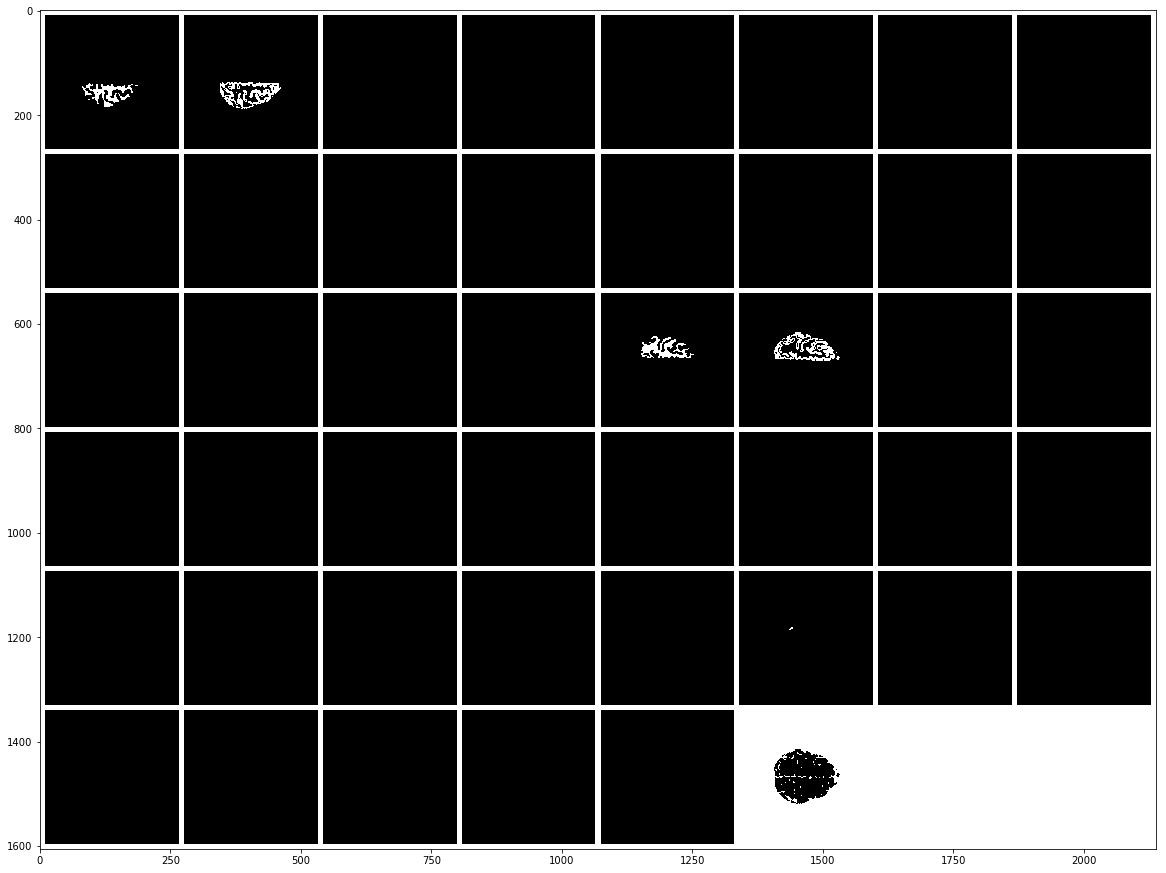

----------------------------------------------------------------------------------------------------
Prediction


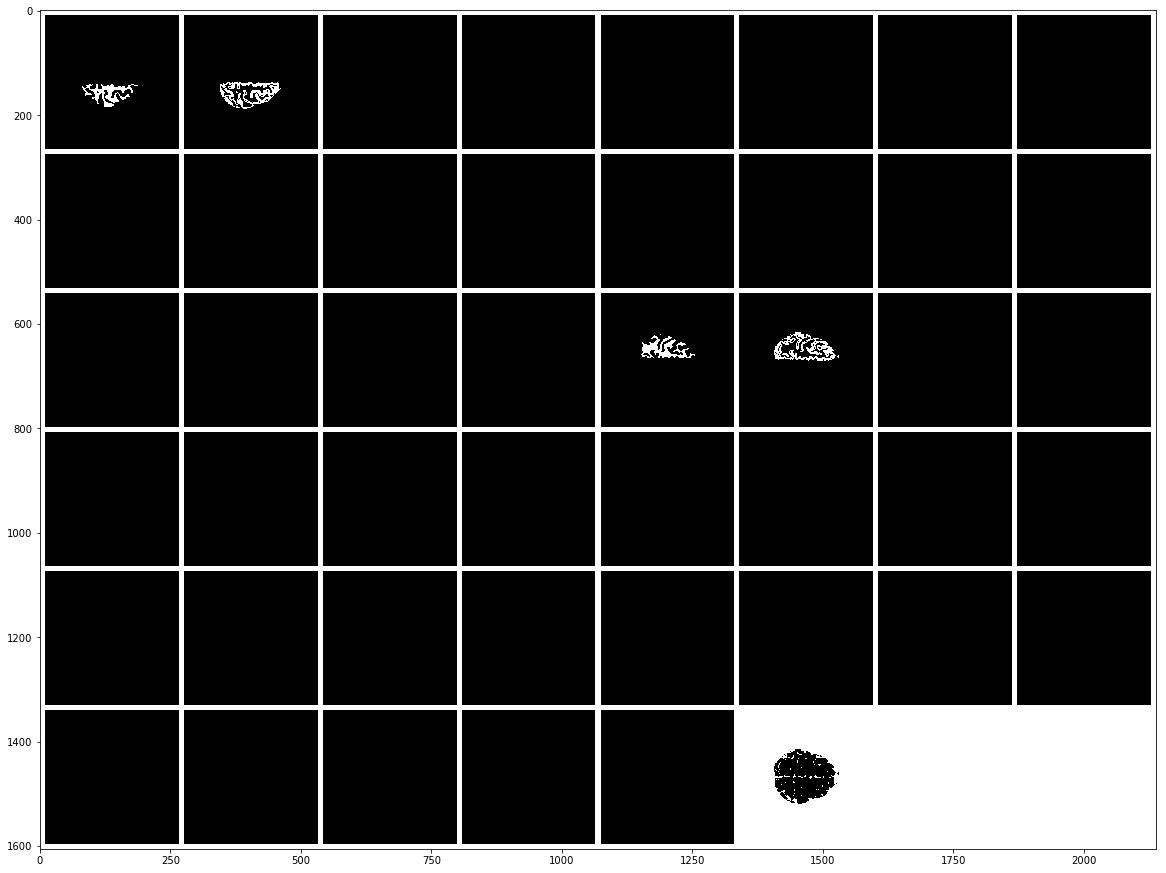

----------------------------------------------------------------------------------------------------
Ground Truth


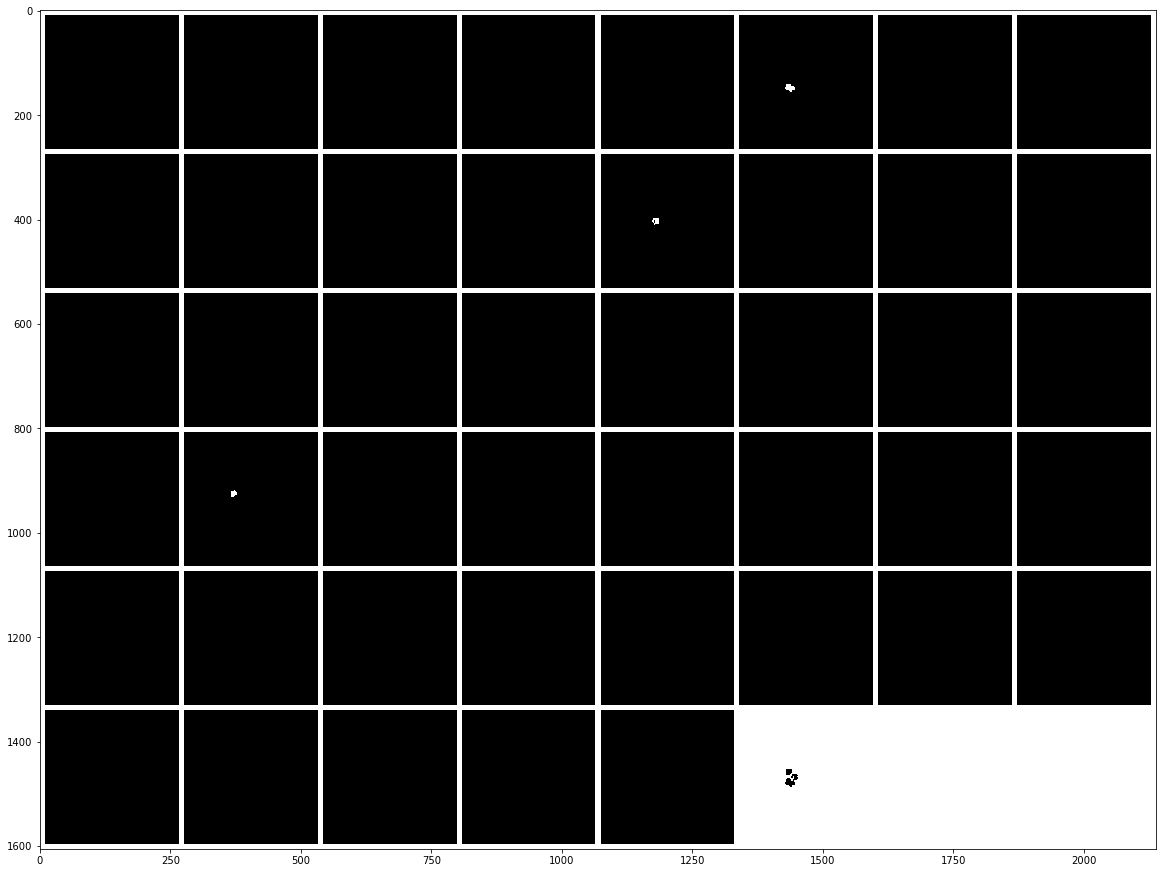

----------------------------------------------------------------------------------------------------
Prediction


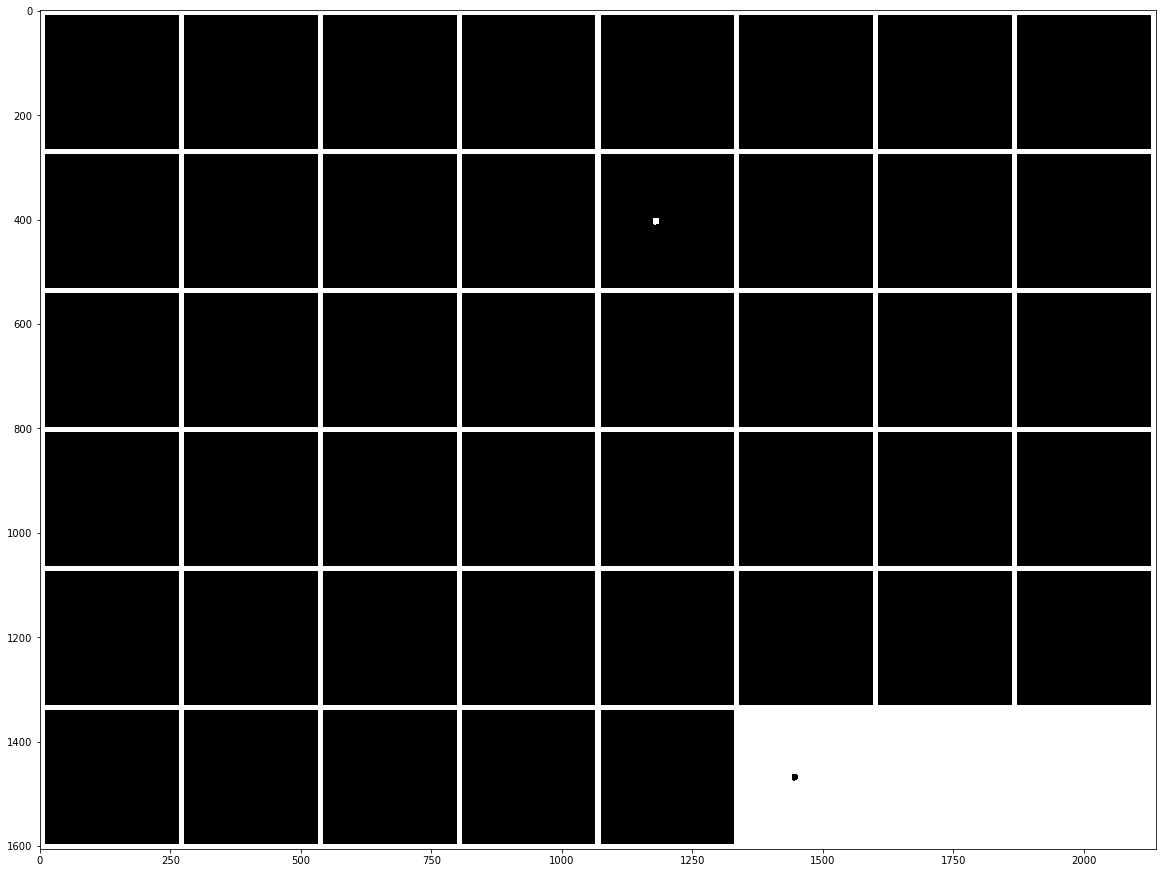

----------------------------------------------------------------------------------------------------
Ground Truth


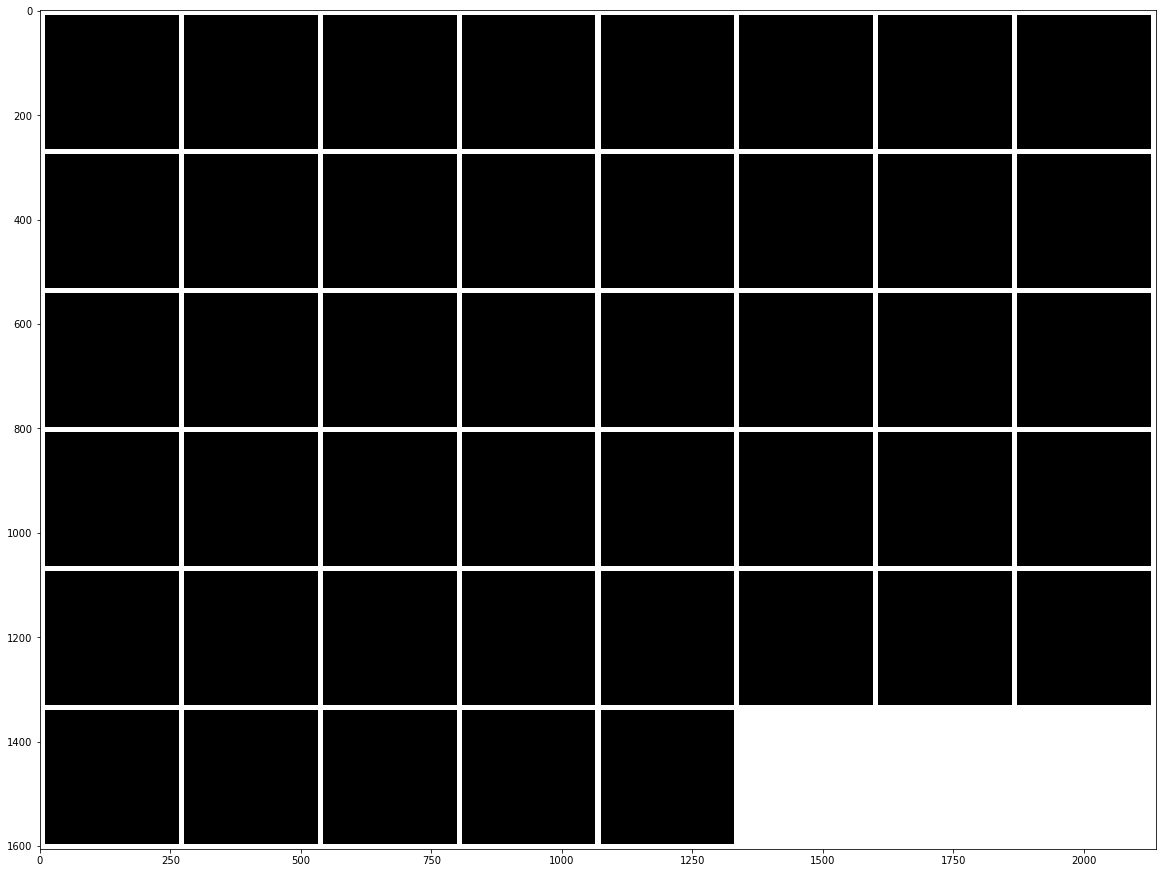

----------------------------------------------------------------------------------------------------
Prediction


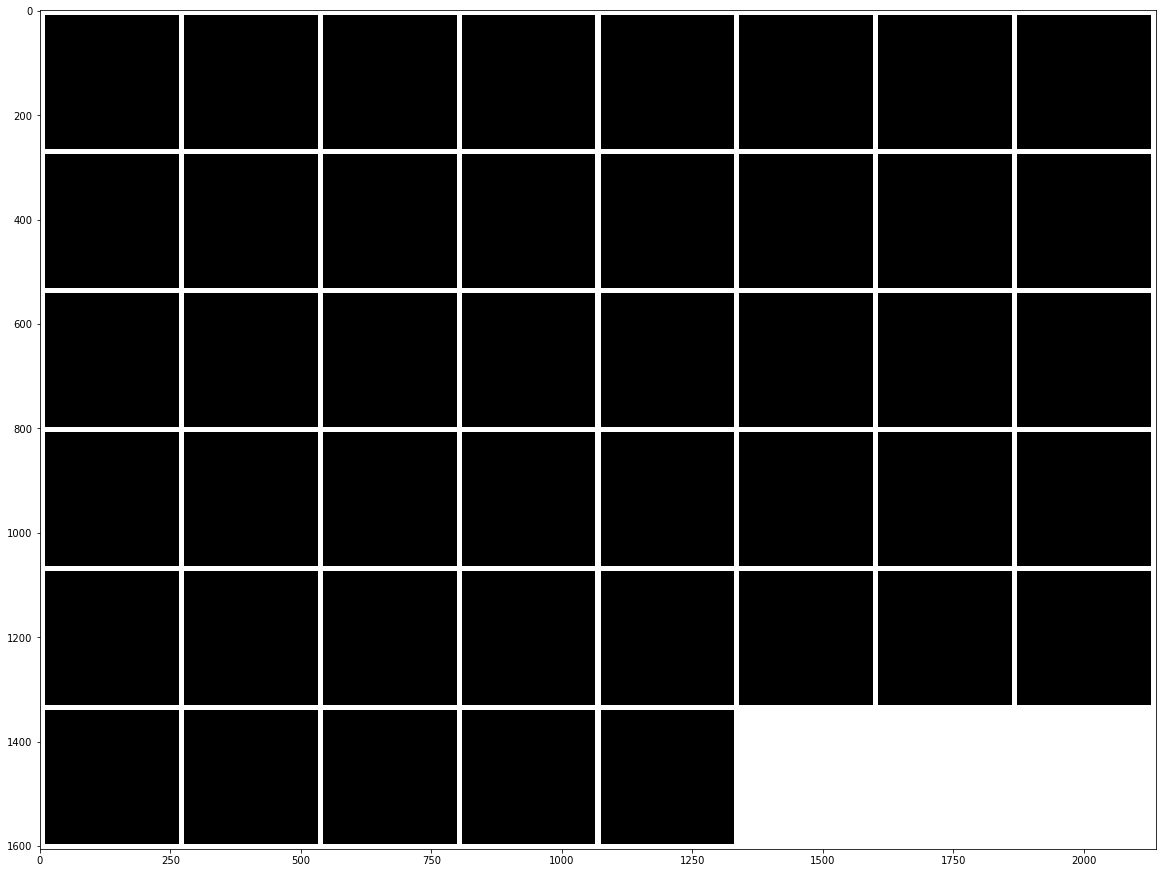

----------------------------------------------------------------------------------------------------
Ground Truth


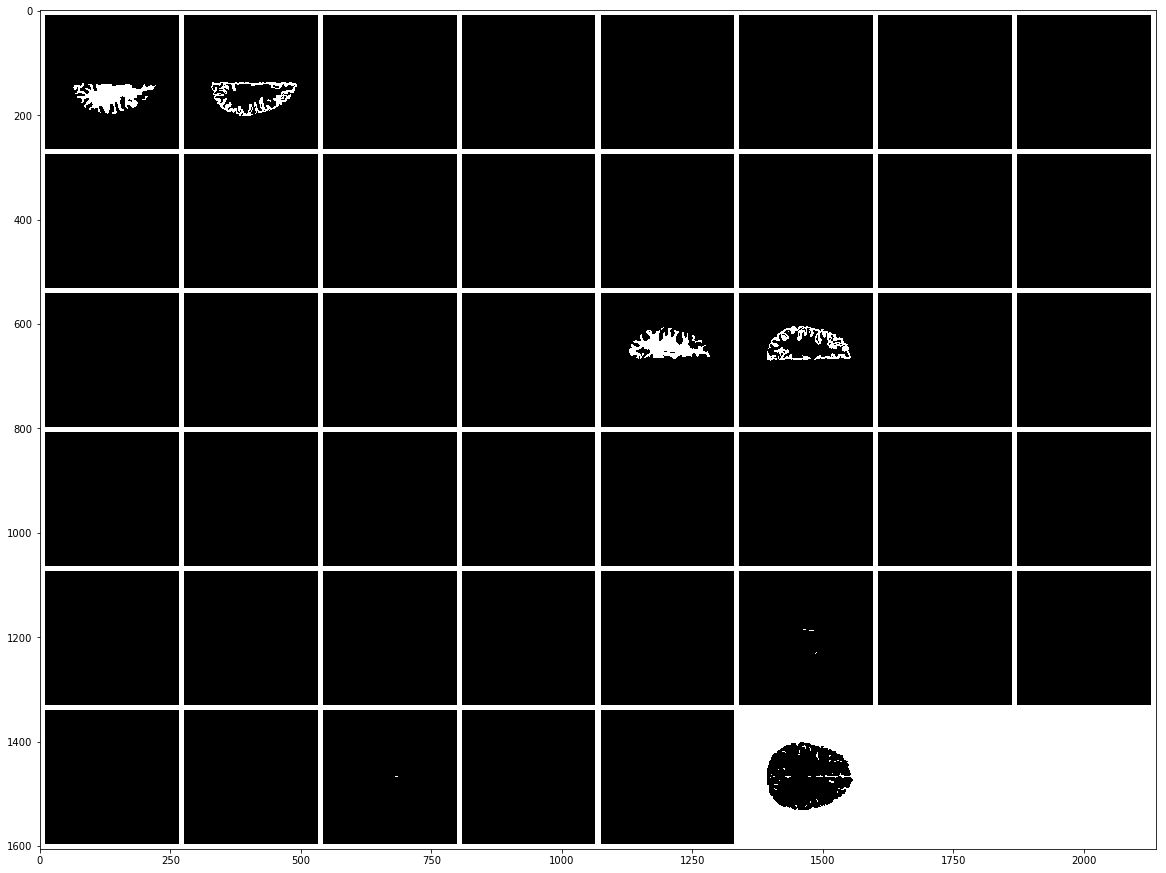

----------------------------------------------------------------------------------------------------
Prediction


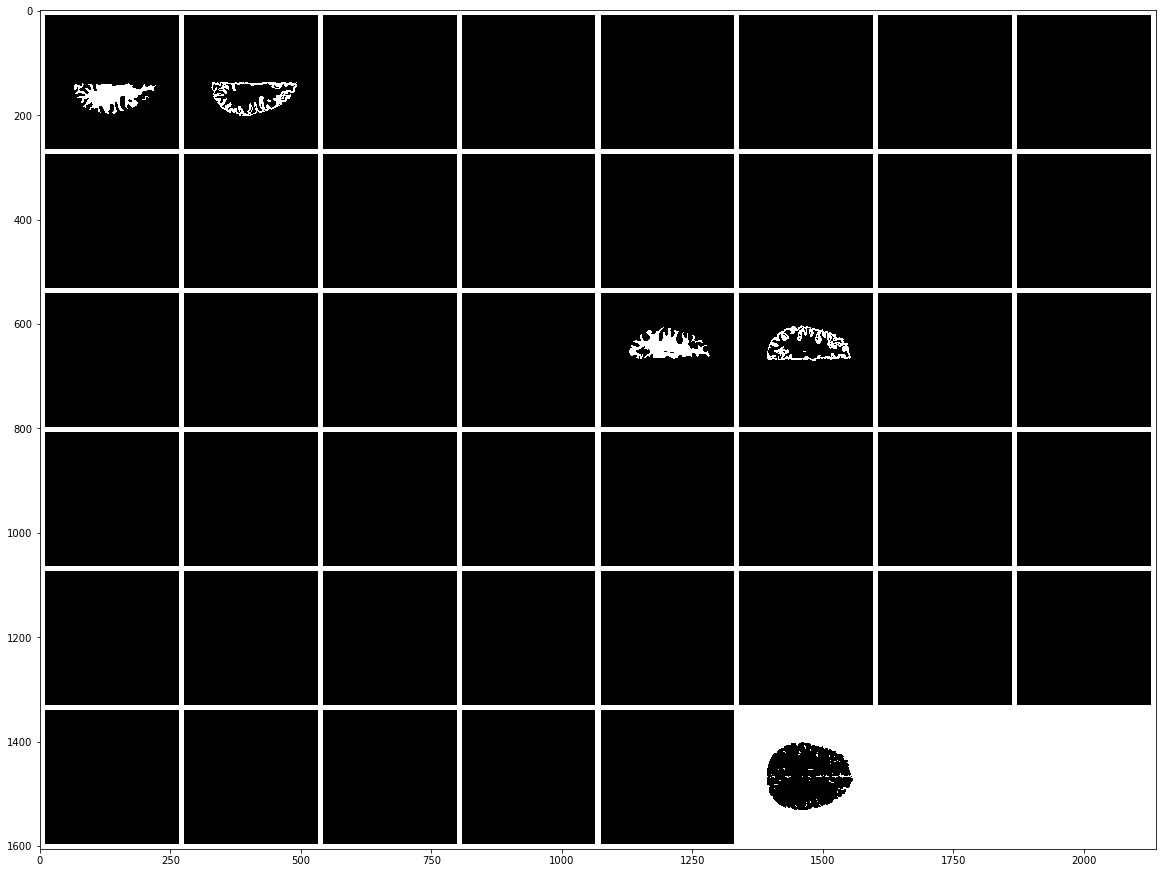

----------------------------------------------------------------------------------------------------
Ground Truth


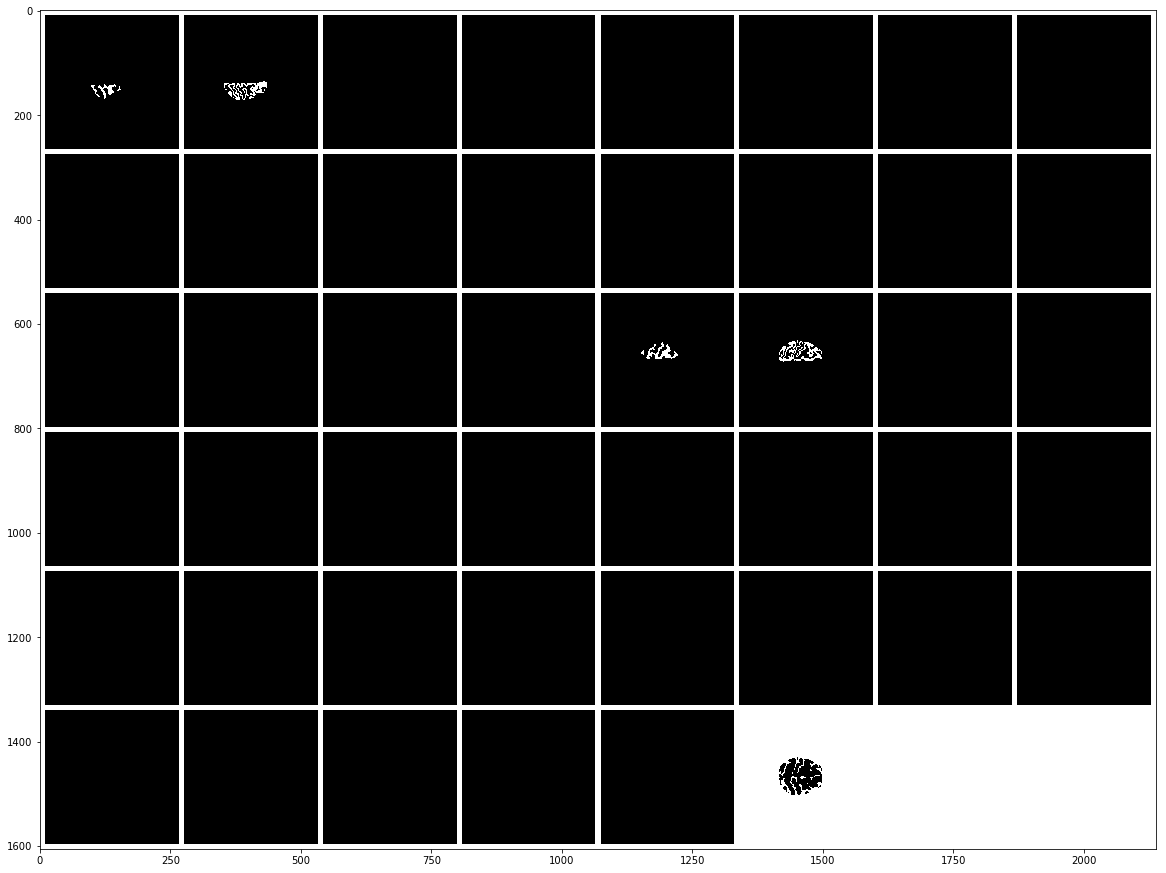

----------------------------------------------------------------------------------------------------
Prediction


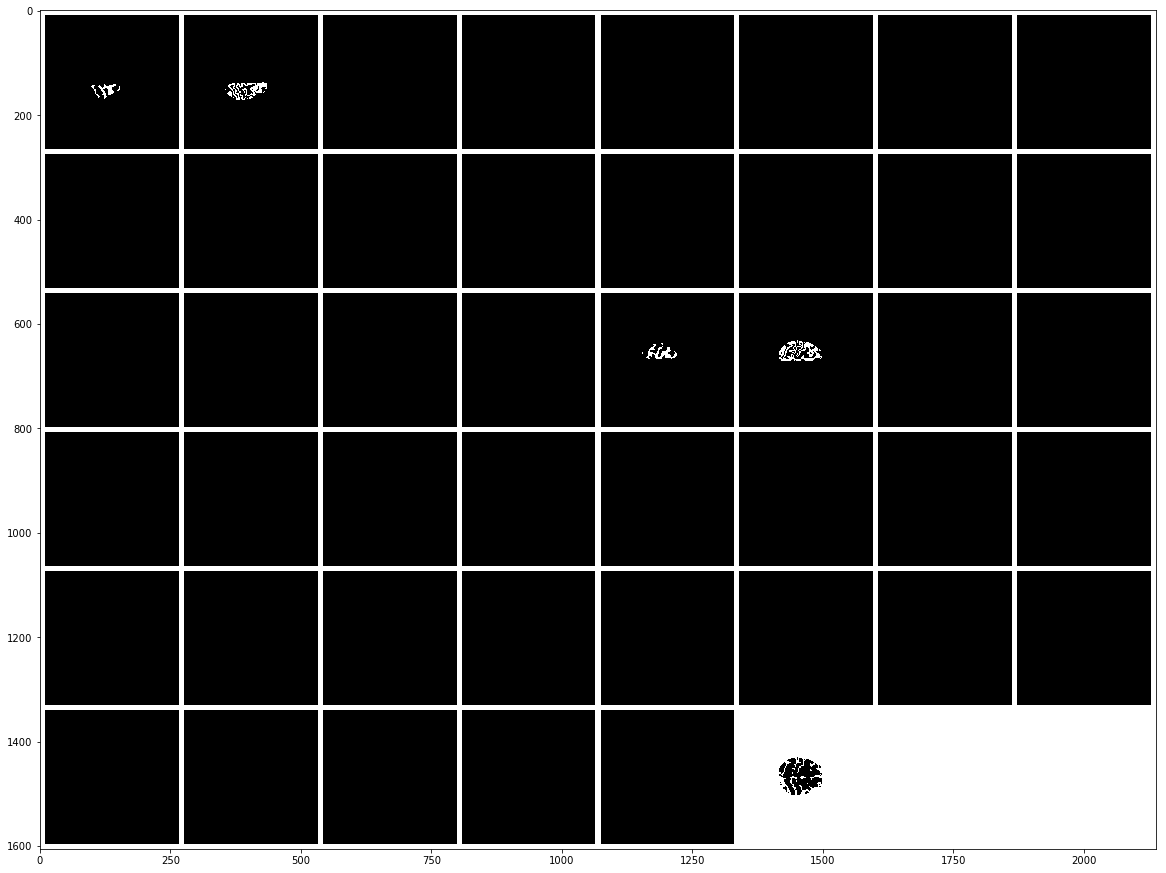

----------------------------------------------------------------------------------------------------
Ground Truth


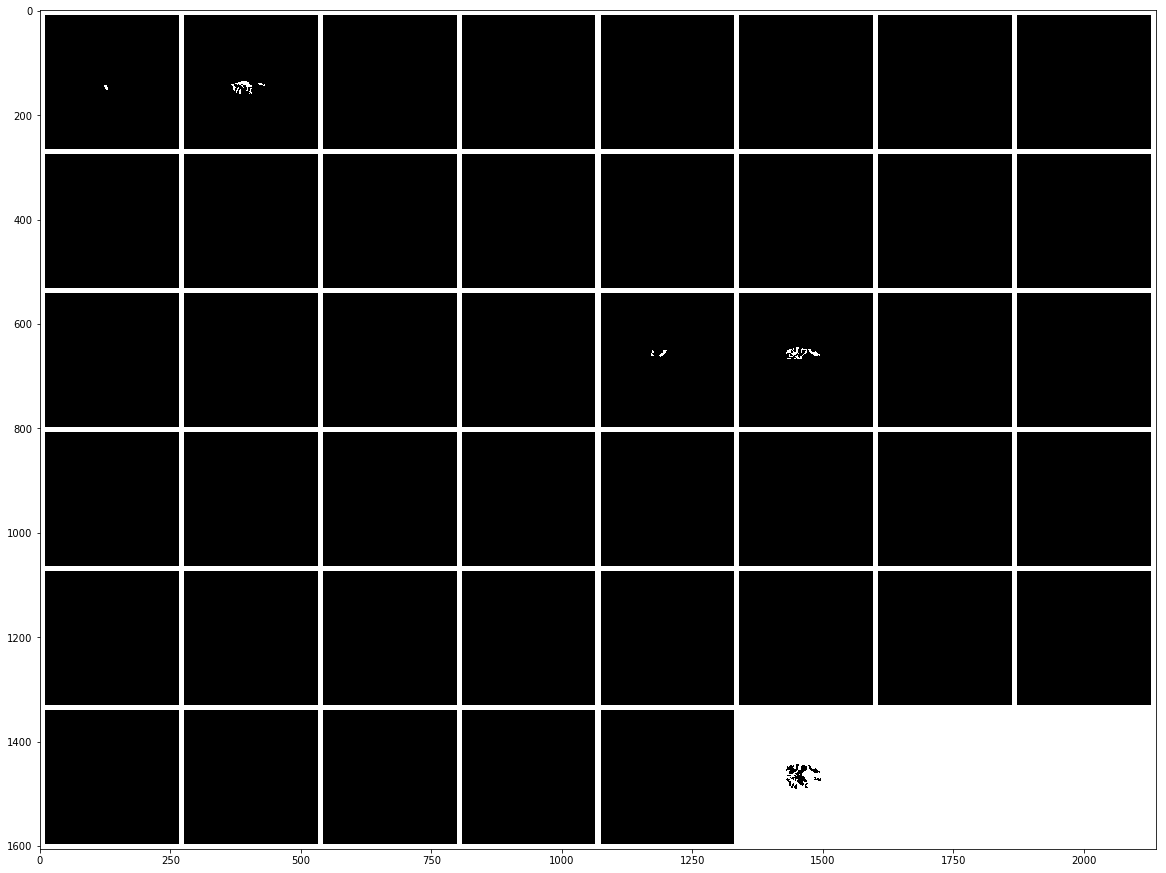

----------------------------------------------------------------------------------------------------
Prediction


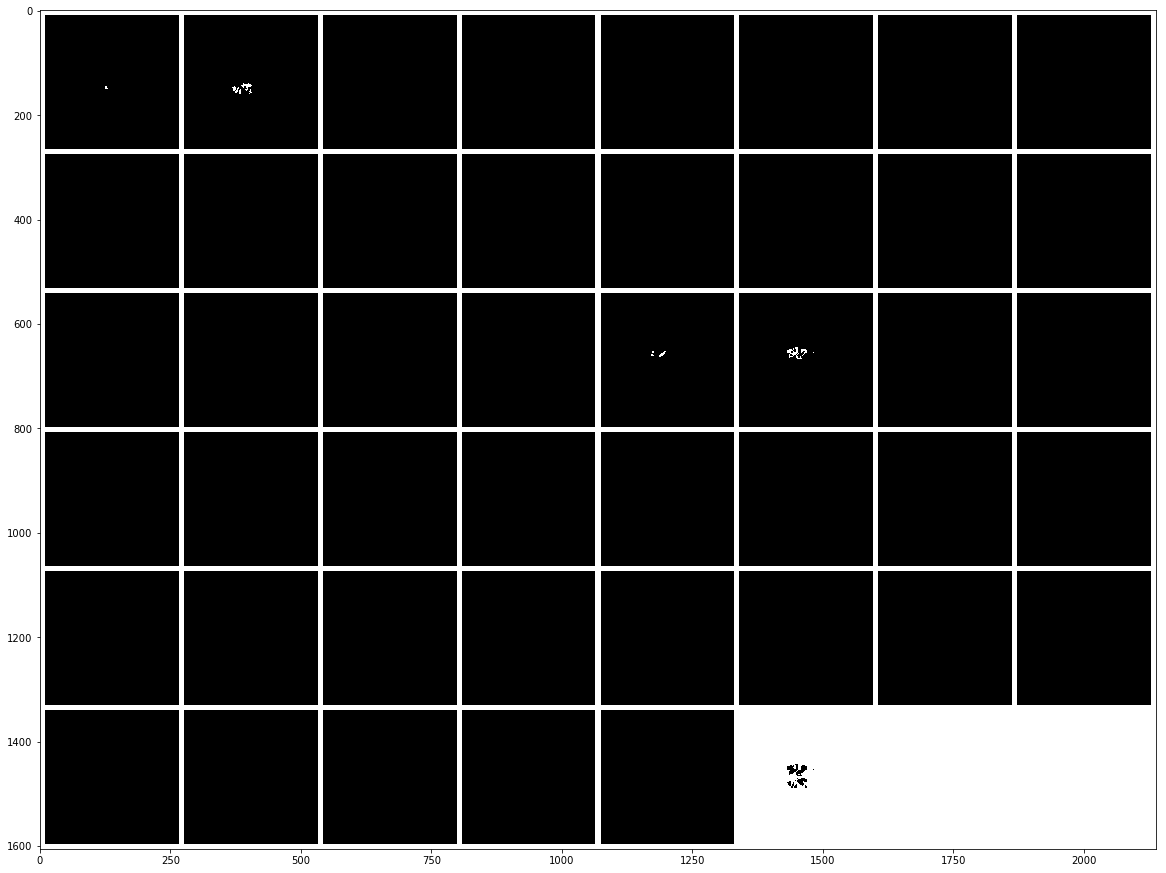

----------------------------------------------------------------------------------------------------
Ground Truth


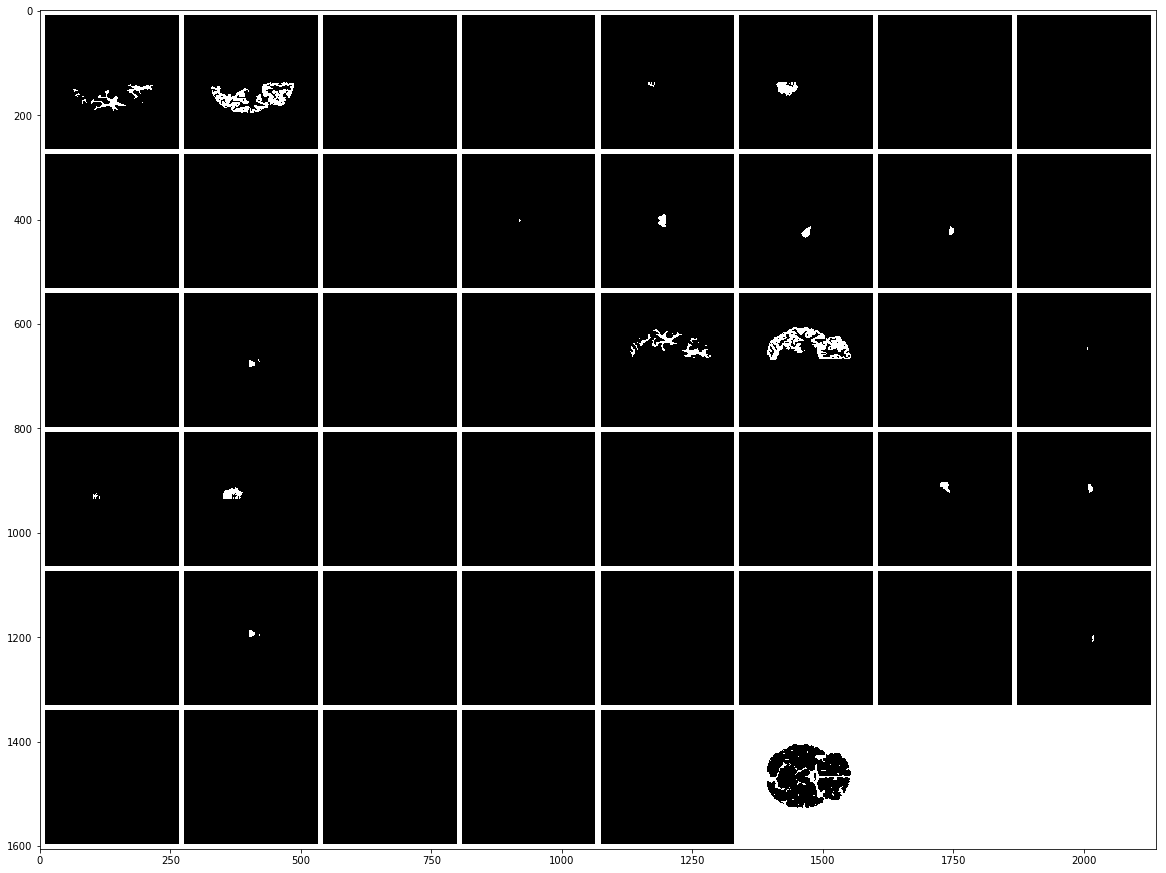

----------------------------------------------------------------------------------------------------
Prediction


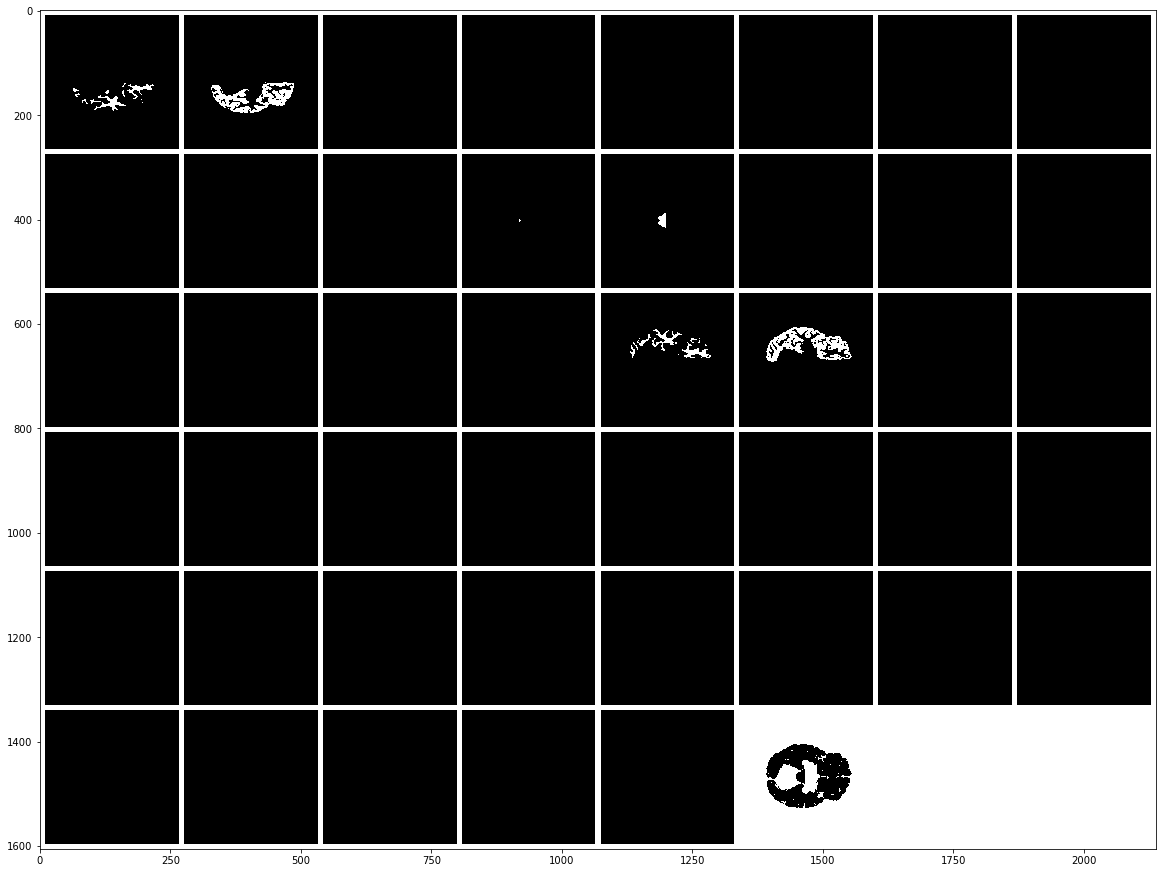

----------------------------------------------------------------------------------------------------
Ground Truth


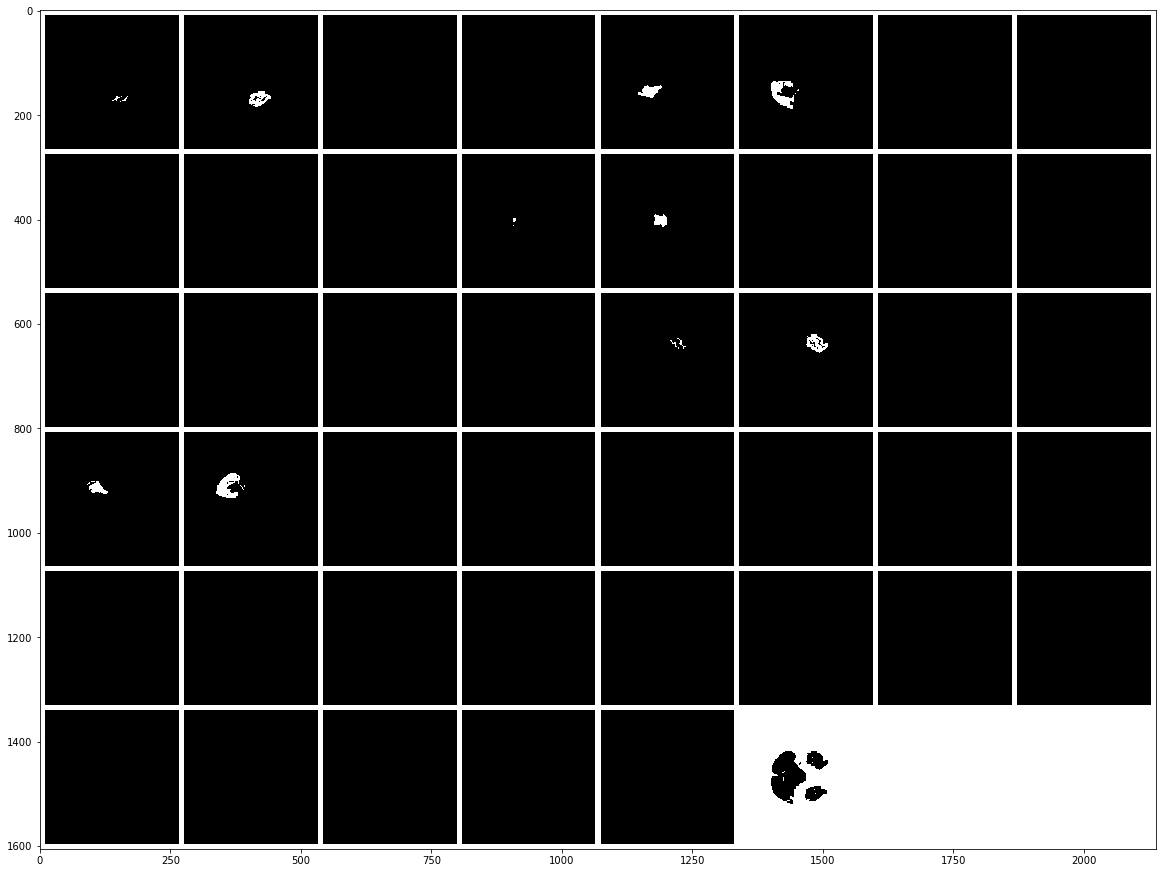

----------------------------------------------------------------------------------------------------
Prediction


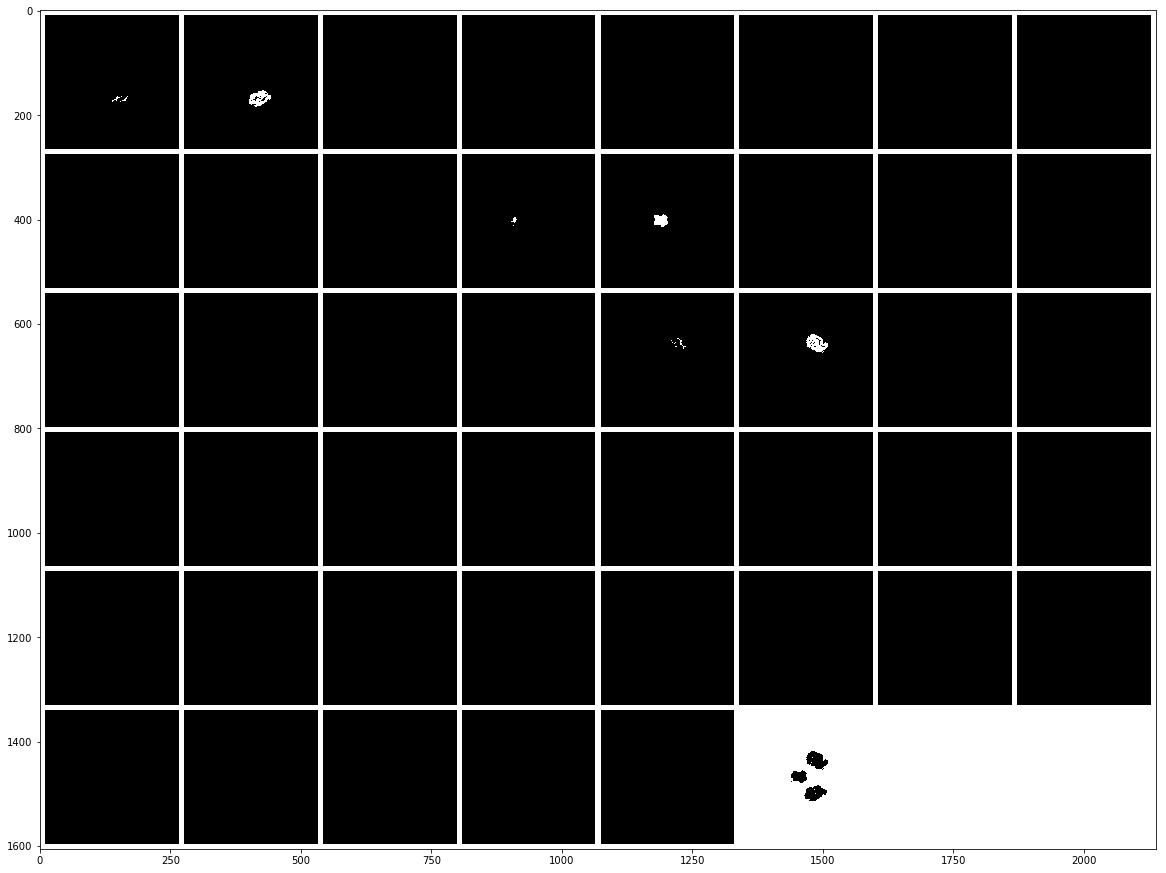

----------------------------------------------------------------------------------------------------
Ground Truth


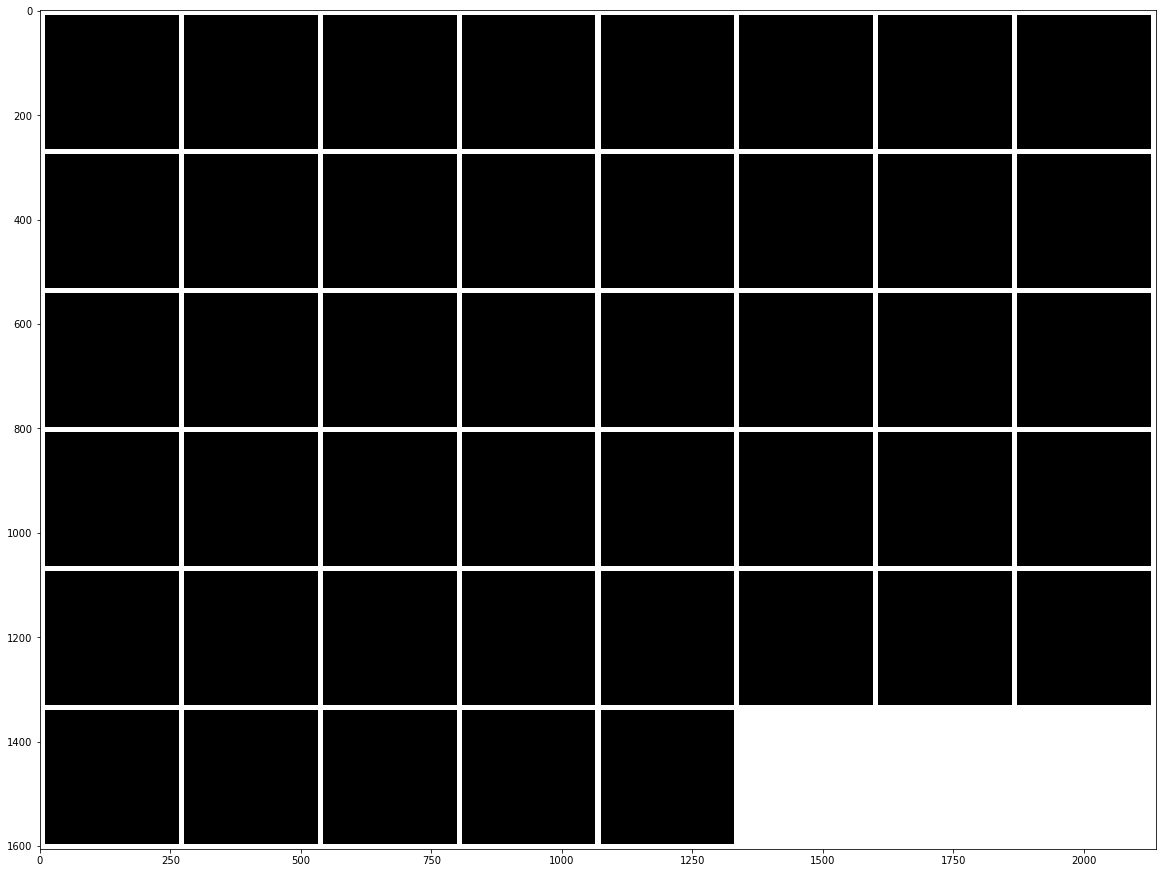

----------------------------------------------------------------------------------------------------
Prediction


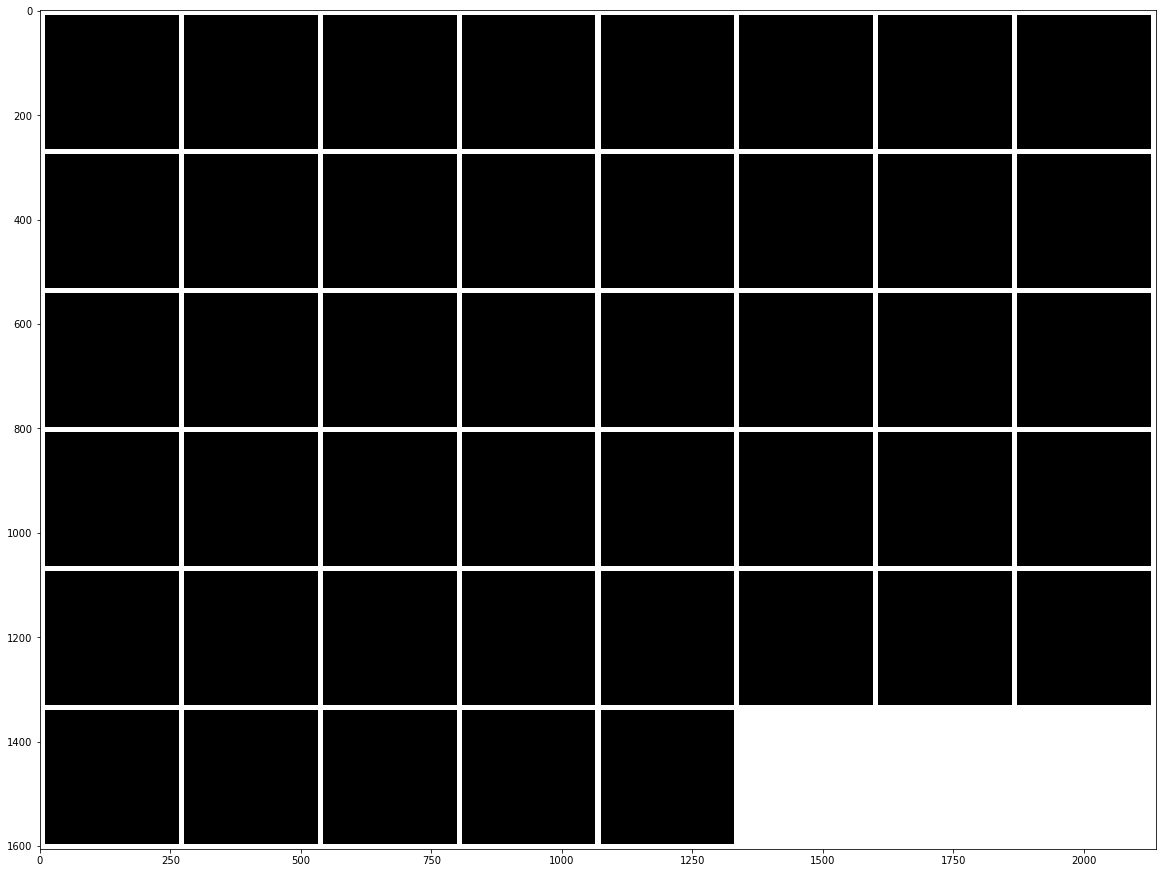

----------------------------------------------------------------------------------------------------
Ground Truth


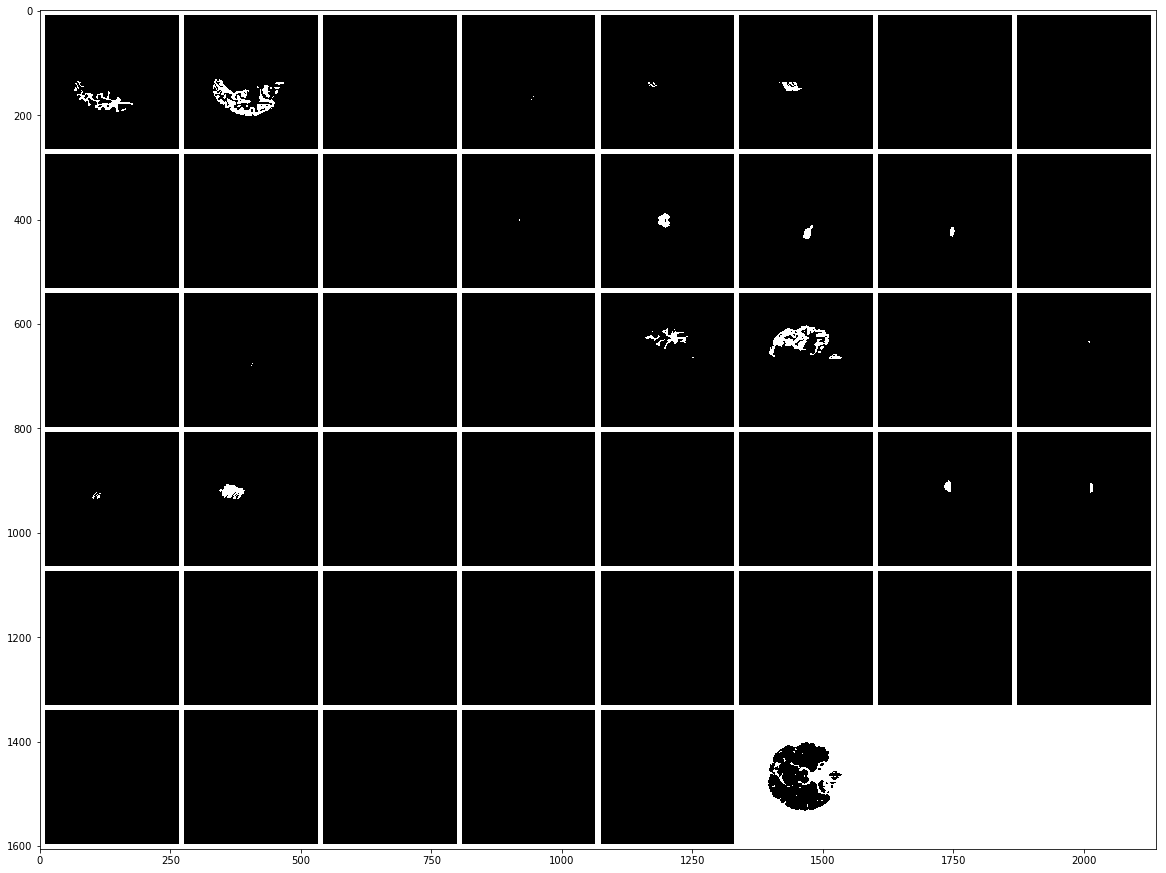

----------------------------------------------------------------------------------------------------
Prediction


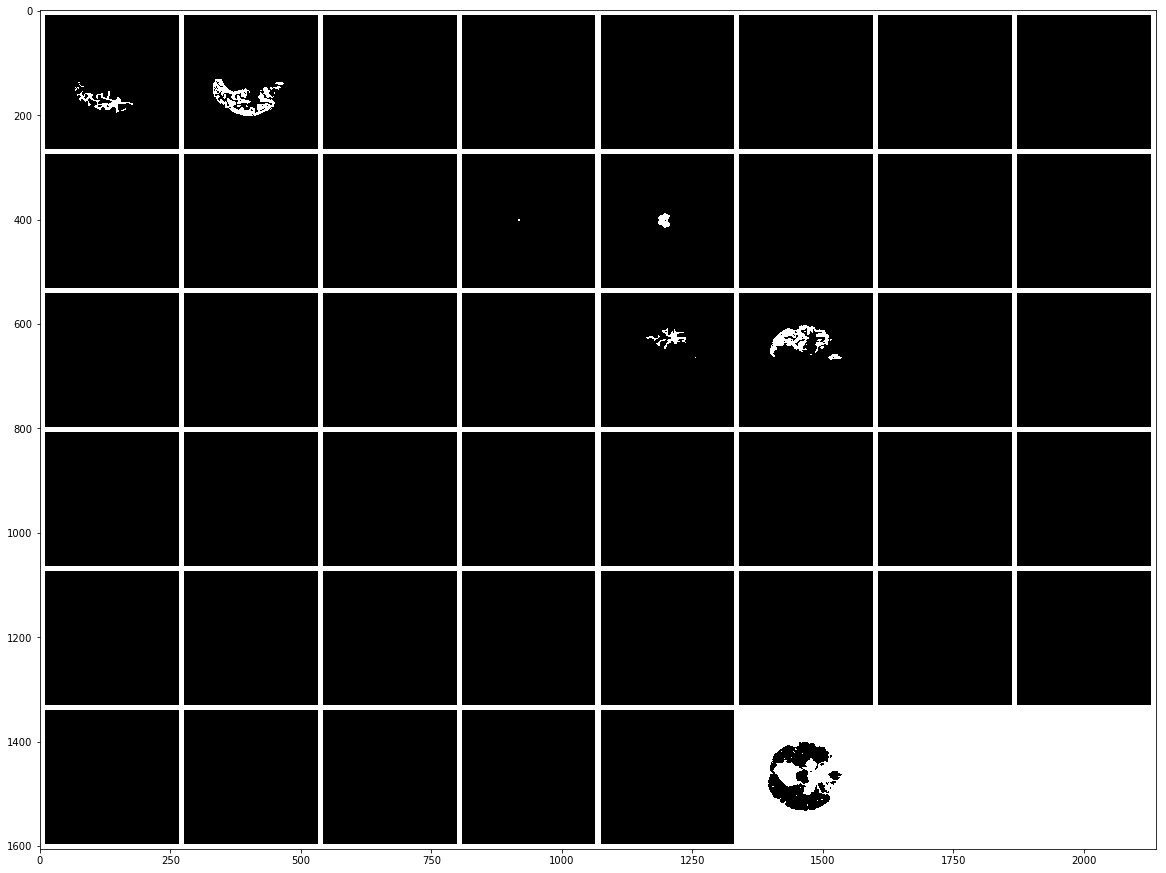

----------------------------------------------------------------------------------------------------
Ground Truth


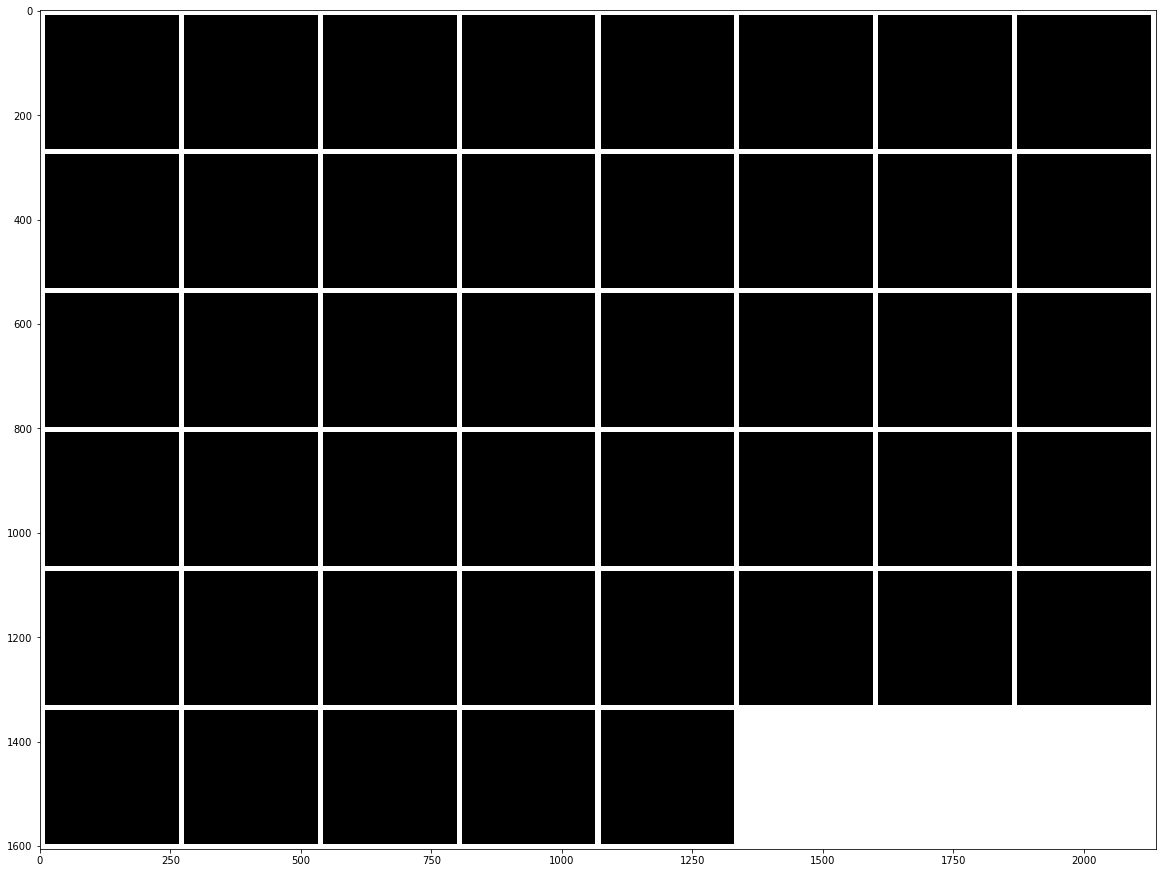

----------------------------------------------------------------------------------------------------
Prediction


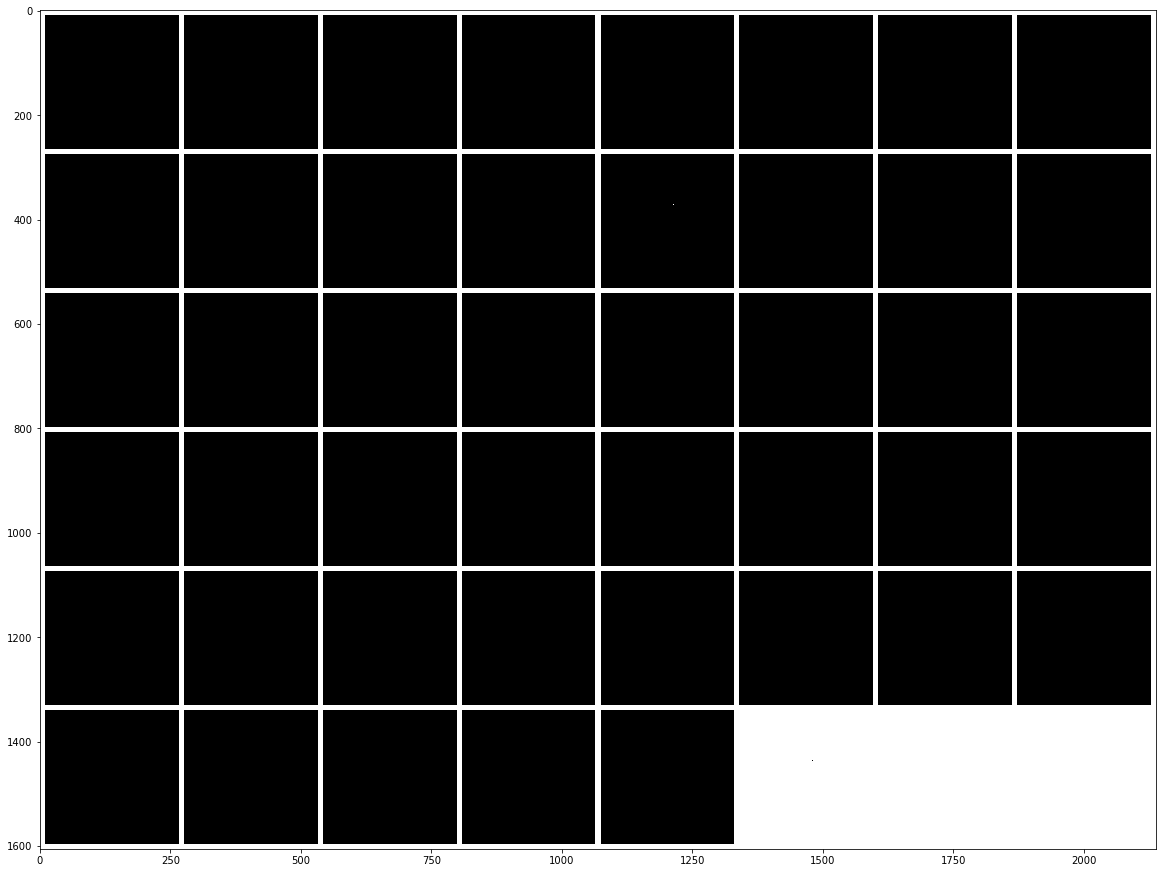

----------------------------------------------------------------------------------------------------
Ground Truth


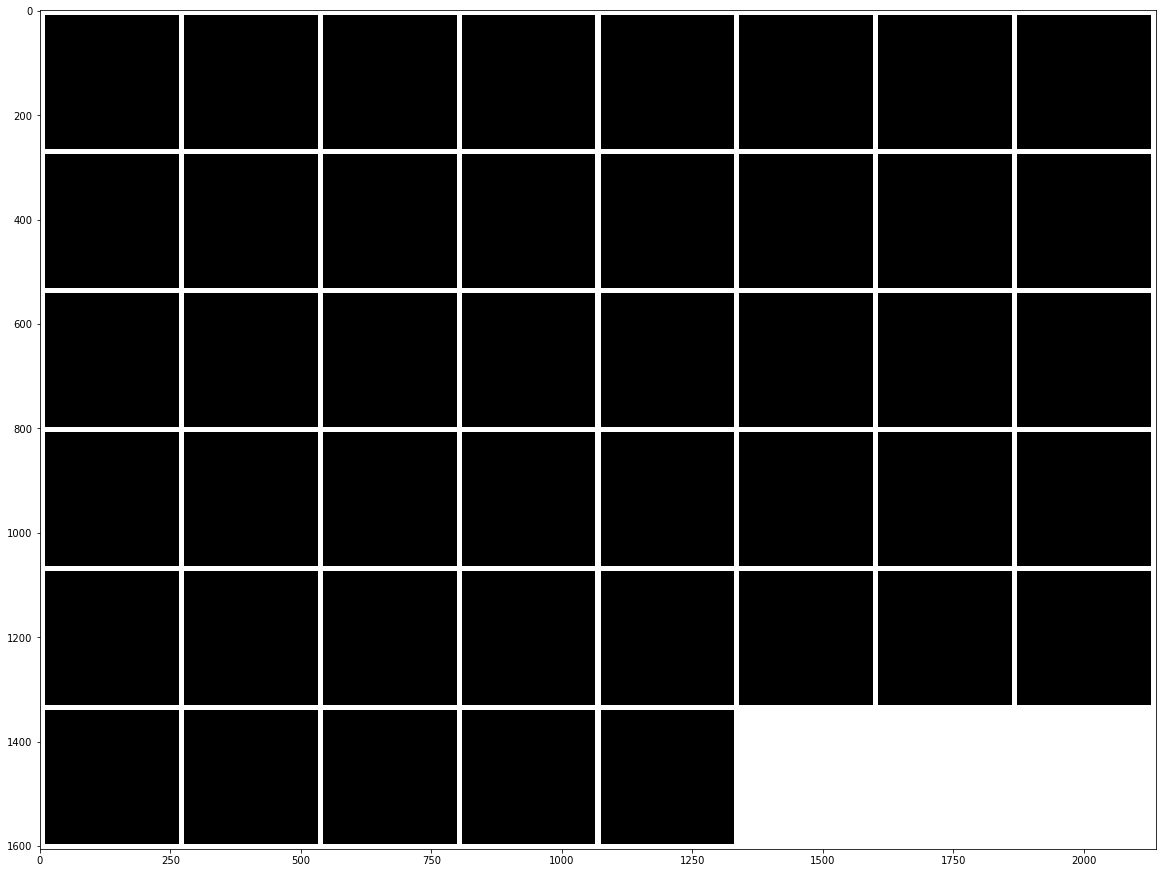

----------------------------------------------------------------------------------------------------
Prediction


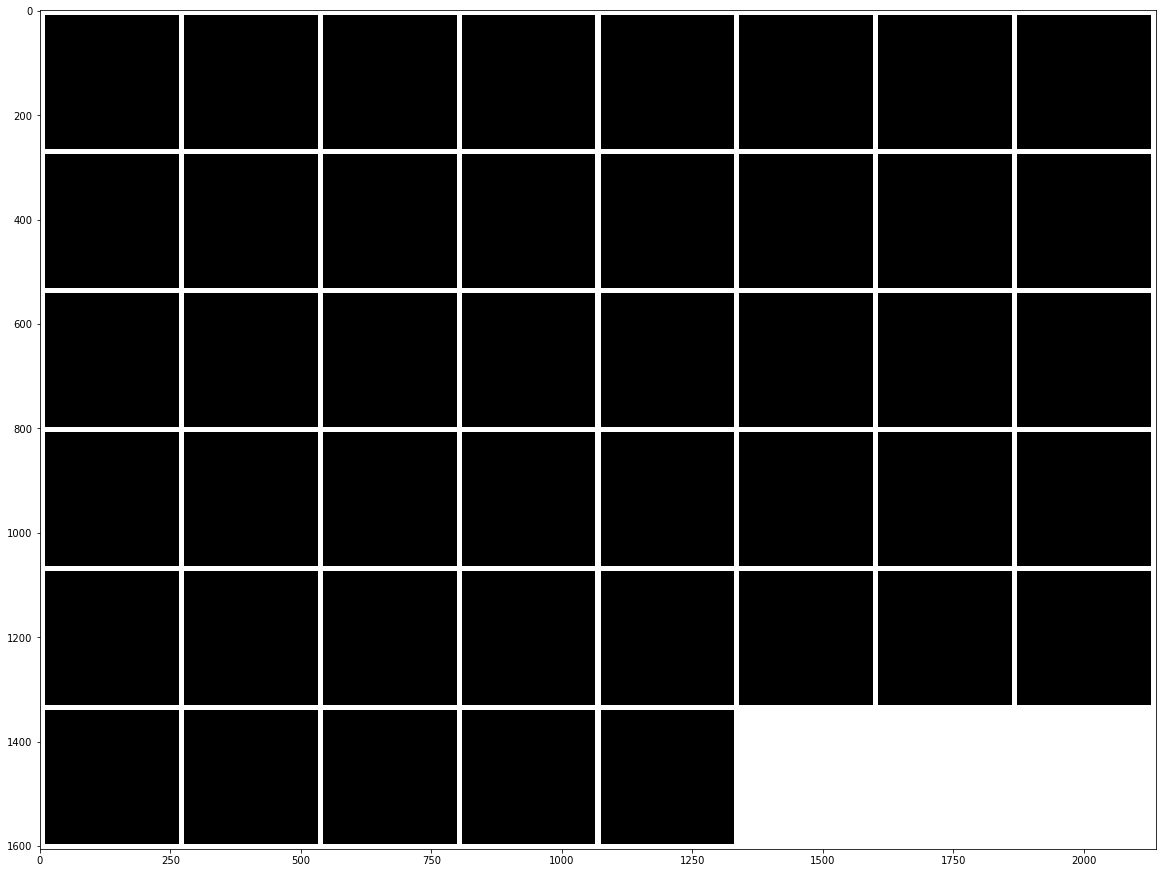

In [41]:
visualize_few()